# Regional Flight Delay Forecasting

This notebook builds regional forecasts of monthly flight delays. The sequence includes data loading, preprocessing, exploratory analysis, model comparison, and final forecasts. The goal is to identify a baseline model that captures delay patterns for each region.

**Source:** https://www.transtats.bts.gov/ (Airline On-Time Performance / Cause of Delay)

**Time period:** 2004 through 2024 (21 years)

The dataset contains **407,721 rows** and **21 variables**, Each row represents a single airport in a given month, and the variables cover monthly arrival statistics, delay counts, delay causes, and flight activity across all U.S. airports.

After cleaning and aggregation, the analysis uses a region-level monthly dataset where each row represents one of five U.S. regions and its total arrival delay minutes for a given month. The final structure contains three columns: the region name, the month (as a datetime value), and the aggregated delay measure. This provides a clean long-term time series for comparing delay behavior across regions and preparing the forecasting models.

This structure makes the dataset suitable for analyzing long-term patterns in U.S. airline arrival delays and for comparing delay behavior across regions over a 21-year period.

## 1) Importing libraries

In [36]:
!pip install pmdarima
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
#from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
#from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series

from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity

from statsmodels.tsa.arima_model import ARIMA #for manual ARIMA
import pmdarima as pm #auto arima

## Data loading and preparation

We import historical flight delay data and prepare it for modeling. The dataset is aggregated to monthly delay counts per region. Basic cleaning ensures a consistent date index and removes incomplete values. The next cell loads the dataset and formats it for time series analysis.

### Loading the Raw Dataset

In [37]:
df = pd.read_csv("Airline_Delay_Cause.csv")
df.shape, df.columns

((407721, 21),
 Index(['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name',
        'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
        'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
        'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
        'security_delay', 'late_aircraft_delay'],
       dtype='object'))

### Creating Region Mapping

In [38]:
regions = {
"North East" : {"WVL", "SFM", "RKD", "PWM", "PQI", "PNN", "PG1", "OWK", "OLD", "MVM", "MLT", "ME98", "ME95", "ME94", "ME93", "ME92", "ME91", "ME90", "ME89", "ME88", "ME87", "ME86", "ME85", "ME84", "ME83", "ME81", "ME80", "ME79", "ME78", "ME77", "ME76", "ME75", "ME74", "ME72", "ME71", "ME70", "ME6", "ME69", "ME68", "ME67", "ME66", "ME65", "ME64", "ME63", "ME62", "ME61", "ME60", "ME5", "ME59", "ME57", "ME55", "ME52", "ME51", "ME50", "ME49", "ME48", "ME47", "ME46", "ME45", "ME44", "ME43", "ME42", "ME41", "ME40", "ME3", "ME39", "ME37", "ME35", "ME34", "ME33", "ME32", "ME30", "ME2", "ME29", "ME28", "ME27", "ME26", "ME25", "ME24", "ME23", "ME22", "ME21", "ME20", "ME19", "ME18", "ME17", "ME16", "ME15", "ME14", "ME12", "ME11", "ME09", "ME08", "ME07", "ME06", "ME05", "ME04", "ME03", "ME02", "ME01", "ME00", "M57", "M00", "LRG", "LEW", "IZG", "IWI", "HUL", "FVE", "EPM", "CAR", "BXM", "BST", "BHB", "BGR", "B21", "B19", "B10", "AUG", "99ME", "98M", "98ME", "93B", "92ME", "92B", "91ME", "90ME", "8ME2", "8B0", "89ME", "88ME", "87ME", "87B", "86ME", "85B", "84ME", "83B", "82ME", "81ME", "81B", "80ME", "7ME", "79ME", "78ME", "78B", "77ME", "76B", "74ME", "72ME", "71ME", "70ME", "70B", "6ME6", "68ME", "68JY", "67ME", "66B", "65B", "64ME", "63ME", "63B", "61ME", "60ME", "60B", "5ME", "5ME9", "5ME2", "59B", "57ME", "57B", "56ME", "55ME", "54ME", "52B", "51ME", "50ME", "4ME9", "4ME4", "49ME", "47ME", "46ME", "45ME", "44ME", "44B", "43B", "42ME", "41ME", "40ME", "3S2", "3ME8", "3ME7", "3B5", "3B4", "3B1", "39ME", "39B", "36ME", "35ME", "30ME", "2ME3", "2ME2", "2B7", "29ME", "27ME", "25ME", "24ME", "22ME", "21ME", "21M", "20ME", "1ME", "1ME2", "1ME1", "1B0", "19ME", "18ME", "17ME", "16ME", "15ME", "14ME", "13ME", "12ME", "10ME", "0ME7", "0ME4", "0B2", "0B1", "09ME", "08ME", "08B", "07ME", "06ME", "06B", "05ME", "05B", "04ME", "03M", "03ME", "02ME", "01ME","PSM", "NH99", "NH98", "NH97", "NH96", "NH94", "NH93", "NH92", "NH91", "NH88", "NH87", "NH86", "NH85", "NH84", "NH83", "NH82", "NH81", "NH80", "NH79", "NH78", "NH77", "NH76", "NH74", "NH73", "NH70", "NH69", "NH68", "NH67", "NH66", "NH65", "NH64", "NH63", "NH62", "NH61", "NH60", "NH59", "NH58", "NH57", "NH56", "NH55", "NH54", "NH53", "NH52", "NH51", "NH50", "NH49", "NH48", "NH47", "NH46", "NH45", "NH44", "NH43", "NH42", "NH41", "NH40", "NH39", "NH38", "NH37", "NH36", "NH35", "NH34", "NH33", "NH32", "NH31", "NH30", "NH29", "NH28", "NH27", "NH26", "NH25", "NH24", "NH23", "NH22", "NH21", "NH20", "NH19", "NH18", "NH17", "NH16", "NH15", "NH14", "NH13", "NH12", "NH11", "NH10", "NH09", "NH08", "NH07", "NH06", "NH05", "NH04", "NH03", "NH02", "NH01", "MHT", "LEB", "LCI", "HIE", "ERR", "EEN", "DAW", "CON", "CNH", "BML", "B18", "ASH", "AFN", "98NH", "95NH", "94NH", "93NH", "92NH", "90NH", "8B2", "8B1", "83NH", "82NH", "7B3", "76NH", "74NH", "73NH", "72NH", "71NH", "70NH", "68NH", "65NH", "63NH", "62NH", "61NH", "60NH", "5B9", "59NH", "58NH", "57NH", "56NH", "55NH", "54NH", "53NH", "52NH", "51NH", "50NH", "4MB", "4C4", "48NH", "46NH", "45NH", "44NH", "43NH", "42NH", "41NH", "3NH9", "3NH4", "3NH2", "37NH", "36NH", "35NH", "34NH", "33NH", "32NH", "31NH", "2NH6", "2NH5", "2NH4", "2NH3", "2NH2", "2NH1", "2N2", "2G8", "2B3", "29NH", "28NH", "27NH", "26NH", "25NH", "24NH", "23NH", "21NH", "1P1", "1B5", "19NH", "18NH", "17NH", "16NH", "15NH", "14NH", "13NH", "12NH", "10NH", "0NH7", "08NH", "07NH", "06NH", "05NH", "03NH", "02NH", "01NH","VT96", "VT95", "VT8", "VT88", "VT80", "VT73", "VT72", "VT70", "VT65", "VT64", "VT63", "VT62", "VT61", "VT60", "VT59", "VT57", "VT56", "VT55", "VT54", "VT53", "VT52", "VT51", "VT50", "VT47", "VT46", "VT45", "VT44", "VT43", "VT42", "VT40", "VT39", "VT38", "VT37", "VT36", "VT34", "VT33", "VT32", "VT31", "VT30", "VT28", "VT26", "VT25", "VT24", "VT23", "VT22", "VT21", "VT17", "VT16", "VT15", "VT14", "VT13", "VT12", "VT11", "VT10", "VT09", "VT08", "VT06", "VT04", "VT03", "VT01", "VSF", "RUT", "MVL", "MPV", "FSO", "EFK", "DDH", "CDA", "BTV", "B06", "88VT", "6B0", "67VT", "66VT", "60VT", "5B1", "57VT", "54VT", "4V8", "48VT", "47VT", "42VT", "38VT", "37VT", "36VT", "33VT", "2VT2", "2B9", "29VT", "28VT", "26VT", "22VT", "1VT8", "19VT", "18VT", "11VT", "0B7", "07VT", "05VT", "04VT","TAN", "PYM", "PVC", "PSF", "OWD", "ORH", "ORE", "MVY", "MA99", "MA98", "MA97", "MA96", "MA95", "MA94", "MA93", "MA92", "MA89", "MA88", "MA87", "MA86", "MA85", "MA84", "MA83", "MA81", "MA80", "MA79", "MA78", "MA77", "MA76", "MA74", "MA71", "MA70", "MA6", "MA69", "MA68", "MA67", "MA66", "MA65", "MA64", "MA63", "MA62", "MA60", "MA57", "MA55", "MA54", "MA53", "MA52", "MA51", "MA50", "MA49", "MA48", "MA47", "MA46", "MA45", "MA44", "MA43", "MA42", "MA41", "MA40", "MA39", "MA38", "MA37", "MA36", "MA35", "MA34", "MA33", "MA32", "MA31", "MA30", "MA29", "MA27", "MA26", "MA25", "MA23", "MA22", "MA21", "MA20", "MA18", "MA17", "MA16", "MA15", "MA14", "MA13", "MA12", "MA11", "MA10", "MA09", "MA03", "MA02", "MA01", "LWM", "HYA", "GHG", "GDM", "GBR", "FMH", "FIT", "EWB", "CQX", "CEF", "BVY", "BOS", "BED", "BAF", "AQW", "ACK", "9MA8", "92MA", "8MA4", "8B5", "87MA", "85MA", "80MA", "7MA2", "7MA1", "7MA0", "7B2", "70MA", "6MA9", "6MA8", "6MA7", "6MA6", "6MA5", "6MA4", "6MA3", "6MA2", "6MA1", "6MA0", "6B6", "69MA", "60M", "60MA", "5MA8", "5MA7", "5MA6", "5MA5", "5MA4", "5MA3", "5MA2", "5MA0", "5B6", "58MA", "57MA", "51MA", "4MA8", "4MA7", "4MA6", "4MA4", "4MA3", "4MA1", "4MA0", "47MA", "42MA", "41MA", "40MA", "3MA9", "3MA7", "3MA5", "3MA4", "3MA3", "3MA2", "3MA1", "3MA0", "3B3", "3B0", "37MA", "36MA", "35MA", "34MA", "33MA", "32MA", "31MA", "30MA", "2MA9", "2MA8", "2MA7", "2MA5", "2MA4", "2MA3", "2MA2", "2B2", "2B1", "29MA", "28M", "28MA", "27MA", "26MA", "25MA", "24MA", "23MA", "22MA", "20MA", "1MA9", "1MA8", "1MA7", "1MA6", "1MA5", "1MA4", "1MA2", "1MA1", "1MA0", "1M8", "1B9", "1B6", "1B2", "19MA", "18MA", "17MA", "16MA", "15MA", "14MA", "12MA", "11MA", "10MA", "0MA9", "0MA6", "0MA5", "0MA4", "0MA3", "0MA2", "0MA1", "0B5", "07MA", "06MA", "05MA", "04MA", "03MA", "02MA", "01MA","WST", "UUU", "SFZ", "RI30", "RI28", "RI26", "RI25", "RI23", "RI21", "RI13", "RI11", "RI08", "RI07", "RI02", "RI01", "PVD", "OQU", "BID", "75RI", "40RI", "2RI7", "29RI", "08R", "02RI","SNC", "OXC", "N41", "N09", "MMK", "LZD", "JSD", "IJD", "HVN", "HFD", "GON", "DXR", "CT98", "CT97", "CT96", "CT95", "CT93", "CT92", "CT91", "CT89", "CT88", "CT87", "CT86", "CT85", "CT84", "CT80", "CT78", "CT76", "CT75", "CT74", "CT73", "CT71", "CT69", "CT66", "CT62", "CT60", "CT59", "CT56", "CT53", "CT52", "CT50", "CT48", "CT46", "CT43", "CT42", "CT41", "CT40", "CT39", "CT38", "CT37", "CT36", "CT35", "CT32", "CT31", "CT30", "CT29", "CT28", "CT27", "CT25", "CT24", "CT23", "CT21", "CT20", "CT19", "CT16", "CT15", "CT14", "CT13", "CT12", "CT11", "CT10", "CT09", "CT07", "CT06", "CT05", "CT04", "CT03", "CT02", "CT01", "CT00", "C44", "BDR", "BDL", "9CT1", "9B8", "84CT", "7B9", "7B6", "6Y2", "69CT", "64CT", "5CT8", "5CT7", "5CT6", "5CT5", "5CT4", "5CT3", "5CT1", "4C3", "4B9", "4B8", "42B", "33CT", "31CT", "24CT", "23CT", "20CT", "1CT3", "1CT2", "1CT0", "14CT", "11N", "10CT", "0CT9", "0CT8", "0CT7", "0CT6", "0CT5", "0CT3", "0CT2", "0CT1", "0CT0", "08CT", "07CT", "05CT", "04CT", "02CT", "01CT","W57", "VGC", "T27", "SYR", "SWF", "SLK", "SDC", "SCH", "ROC", "RME", "PTD", "POU", "PEO", "PBG", "OLE", "OIC", "OGS", "NY9", "NY99", "NY98", "NY97", "NY96", "NY95", "NY94", "NY93", "NY92", "NY91", "NY90", "NY89", "NY88", "NY87", "NY86", "NY85", "NY83", "NY82", "NY80", "NY79", "NY78", "NY77", "NY76", "NY75", "NY74", "NY73", "NY72", "NY70", "NY69", "NY68", "NY67", "NY66", "NY65", "NY64", "NY63", "NY62", "NY61", "NY60", "NY59", "NY58", "NY57", "NY55", "NY54", "NY53", "NY52", "NY51", "NY50", "NY49", "NY48", "NY47", "NY46", "NY45", "NY44", "NY43", "NY42", "NY41", "NY40", "NY39", "NY38", "NY37", "NY36", "NY35", "NY34", "NY33", "NY32", "NY31", "NY30", "NY29", "NY28", "NY27", "NY26", "NY25", "NY24", "NY23", "NY22", "NY21", "NY20", "NY1", "NY19", "NY18", "NY17", "NY16", "NY15", "NY14", "NY13", "NY12", "NY11", "NY10", "NY0", "NY08", "NY07", "NY06", "NY05", "NY04", "NY03", "NY02", "NY01", "NY00", "NK96", "NK95", "NK92", "NK91", "NK90", "NK89", "NK87", "NK86", "NK84", "NK83", "NK82", "NK80", "NK79", "NK78", "NK77", "NK76", "NK75", "NK74", "NK73", "NK72", "NK71", "NK68", "NK67", "NK65", "NK64", "NK63", "NK61", "NK58", "NK57", "NK56", "NK55", "NK54", "NK53", "NK51", "NK50", "NK49", "NK48", "NK47", "NK43", "NK40", "NK39", "NK38", "NK37", "NK35", "NK34", "NK33", "NK32", "NK31", "NK30", "NK29", "NK27", "NK26", "NK24", "NK23", "NK19", "NK18", "NK17", "NK16", "NK15", "NK14", "NK13", "NK12", "NK11", "NK09", "NK08", "NK05", "NK04", "NK01", "N89", "N82", "N72", "N69", "N66", "N56", "N45", "N25", "N23", "N03", "MTP", "MSV", "MSS", "MGJ", "MAL", "LKP", "LGA", "K31", "K30", "K23", "K21", "K16", "K09", "K03", "JRB", "JRA", "JPX", "JHW", "JFK", "IUA", "ITH", "ISP", "IAG", "HWV", "HTF", "HPN", "H43", "GVQ", "GTB", "GFL", "FZY", "FRG", "FOK", "ELZ", "ELM", "DSV", "DKK", "D91", "D88", "D82", "D80", "D79", "D59", "D52", "D51", "D23", "CZG", "BUF", "BQR", "BGM", "B16", "B04", "ART", "ALB", "9NY9", "9NY8", "9NY7", "9NY6", "9NY5", "9NY4", "9NY3", "9NY2", "9NY1", "9NY0", "9NK4", "9NK2", "9G6", "9G5", "9G3", "9G0", "99NY", "98NY", "96NY", "95NY", "94NY", "93NY", "92NY", "92G", "91NY", "90NY", "8NY9", "8NY8", "8NY7", "8NY6", "8NY5", "8NY4", "8NY3", "8NY2", "8NY1", "8NK8", "8NK6", "8NK5", "8NK4", "8NK3", "8G3", "89NY", "88NY", "87NY", "87N", "85NY", "85NK", "85N", "84NY", "84NK", "83K", "82NY", "80NY", "7NY9", "7NY8", "7NY7", "7NY6", "7NY5", "7NY4", "7NY3", "7NY1", "7NY0", "7NK8", "7NK7", "7NK6", "7NK4", "7NK2", "7NK0", "7N3", "7N1", "7G0", "79NY", "78NY", "77NY", "75NY", "75NK", "74NY", "74NK", "73NY", "72NY", "71NY", "70NY", "6NY9", "6NY8", "6NY7", "6NY6", "6NY5", "6NY4", "6NY3", "6NY2", "6NY1", "6NY0", "6NK9", "6NK6", "6NK5", "6NK3", "6NK2", "6NK0", "6N7", "6N6", "6N5", "6JY8", "6B9", "6B4", "69NY", "68NY", "68NK", "66NY", "65NY", "65NK", "63NY", "60NY", "5R5", "5NY5", "5NY4", "5NY3", "5NY1", "5NK9", "5NK8", "5NK7", "5NK6", "5NK5", "5NK4", "5NK3", "5NK2", "5NK1", "5G0", "5B7", "5B2", "59NY", "58NY", "57NY", "56NY", "56NK", "55NY", "55NK", "54NY", "53NY", "52NY", "52NK", "51NK", "50NY", "4NY9", "4NY8", "4NY7", "4NY5", "4NY4", "4NY3", "4NY2", "4NY1", "4NY0", "4NK9", "4NK7", "4NK5", "4NK4", "4NK3", "4NK2", "4NK0", "4N7", "4N2", "4G2", "4B7", "4B6", "4B1", "4B0", "49NY", "49N", "49NK", "48NY", "47NY", "46NY", "45NY", "44NY", "44N", "44NK", "43NY", "42NY", "41NY", "41NK", "40NY", "3NY9", "3NY8", "3NY7", "3NY6", "3NY5", "3NY3", "3NY2", "3NY1", "3NY0", "3NK9", "3NK8", "3NK7", "3NK6", "3NK5", "3NK4", "3NK3", "3NK2", "3NK1", "3NK0", "39NY", "38NY", "37NY", "36NY", "35NY", "35NK", "34NY", "34NK", "33NY", "32NY", "32NK", "30NY", "2NY9", "2NY8", "2NY7", "2NY6", "2NY5", "2NY4", "2NY3", "2NY2", "2NY0", "2NK9", "2NK8", "2NK6", "2NK5", "2NK4", "2NK3", "2NK2", "2N4", "29NY", "29NK", "28NY", "28NK", "27NY", "27NK", "26NY", "25NY", "25NK", "24NY", "24NK", "23NY", "23NK", "23N", "22NY", "22NK", "21N", "21NK", "20NY", "20N", "1NY5", "1NY4", "1NY3", "1NY2", "1NY1", "1NY0", "1NK9", "1NK8", "1NK7", "1NK6", "1NK4", "1NK3", "1NK1", "1NK0", "1N2", "1I5", "1I1", "1H4", "1H1", "1F2", "1E8", "1C3", "1B8", "1B1", "1A1", "19NY", "19NK", "18NY", "17NK", "16NY", "16NK", "15NY", "14NY", "14NK", "13NY", "13NK", "12NY", "12NK", "11NY", "11NK", "10NY", "10NK", "0NY8", "0NY7", "0NY6", "0NY5", "0NY4", "0NY3", "0NY2", "0NY1", "0NY0", "0NK7", "0NK4", "0NK3", "0NK2", "0NK0", "0G7", "0G0", "0B8", "09NY", "09N", "08NY", "07NY", "06NY", "06N", "05NY", "04NY", "03NY", "02NY", "01NY", "01NK", "01G", "00NY", "00NK","WWD", "WRI", "VAY", "TTN", "TEB", "SMQ", "OBI", "NJ99", "NJ97", "NJ95", "NJ94", "NJ93", "NJ92", "NJ90", "NJ89", "NJ87", "NJ85", "NJ84", "NJ82", "NJ79", "NJ78", "NJ77", "NJ76", "NJ74", "NJ73", "NJ72", "NJ71", "NJ66", "NJ65", "NJ63", "NJ62", "NJ61", "NJ60", "NJ59", "NJ57", "NJ55", "NJ54", "NJ53", "NJ51", "NJ50", "NJ48", "NJ46", "NJ44", "NJ41", "NJ40", "NJ38", "NJ37", "NJ36", "NJ33", "NJ29", "NJ28", "NJ27", "NJ26", "NJ25", "NJ24", "NJ23", "NJ22", "NJ20", "NJ19", "NJ17", "NJ15", "NJ13", "NJ12", "NJ10", "NJ09", "NJ08", "NJ05", "NJ04", "NJ03", "NJ02", "NJ01", "NJ00", "NEL", "N87", "N85", "N81", "N51", "N40", "N14", "N12", "N07", "N05", "MMU", "MJX", "MIV", "LDJ", "JY79", "JY73", "JY64", "JY43", "JY42", "JY39", "JY36", "JY35", "JY34", "JY32", "JY31", "JY30", "JY28", "JY27", "JY26", "JY25", "JY24", "JY21", "JY20", "JY18", "JY17", "JY16", "JY15", "JY14", "JY13", "JY12", "JY11", "JY08", "JY06", "JY04", "JY02", "JY01", "JY00", "FWN", "EWR", "CDW", "C01", "BLM", "ACY", "9NJ9", "9NJ8", "9NJ6", "9NJ5", "9NJ4", "9NJ3", "9NJ2", "9NJ1", "99NJ", "98NJ", "96NJ", "95NJ", "94NJ", "92NJ", "91NJ", "90NJ", "8NJ8", "8NJ7", "8NJ6", "8NJ4", "8NJ3", "8NJ2", "8NJ1", "89NJ", "87NJ", "86NJ", "85NJ", "83NJ", "82NJ", "80NJ", "7NJ9", "7NJ8", "7NJ6", "7NJ5", "7NJ3", "7NJ2", "7NJ1", "7NJ0", "7N7", "79NJ", "78NJ", "77NJ", "76NJ", "75NJ", "74NJ", "73NJ", "72NJ", "71NJ", "70NJ", "6NJ9", "6NJ7", "6NJ6", "6NJ5", "6NJ3", "6NJ2", "6NJ1", "68NJ", "67NJ", "66NJ", "65NJ", "64NJ", "63NJ", "61NJ", "60NJ", "5NJ9", "5NJ7", "5NJ6", "5NJ5", "5NJ4", "5NJ3", "5NJ2", "5NJ0", "59NJ", "58NJ", "57NJ", "56NJ", "52NJ", "51NJ", "50NJ", "4NJ8", "4NJ6", "4NJ5", "4NJ4", "4NJ3", "4NJ1", "4NJ0", "4N1", "49NJ", "48NJ", "47NJ", "47N", "45NJ", "44NJ", "42NJ", "42JY", "41NJ", "40NJ", "3NJ9", "3NJ8", "3NJ6", "3NJ5", "3NJ4", "3NJ3", "3NJ2", "3NJ1", "3NJ0", "3N6", "3JY6", "3JY2", "39N", "39NJ", "38NJ", "37NJ", "36NJ", "35NJ", "35JY", "34NJ", "34JY", "33NJ", "32NJ", "31NJ", "31E", "30NJ", "2NJ9", "2NJ8", "2NJ7", "2NJ6", "2NJ5", "2NJ4", "2NJ3", "2NJ2", "2NJ1", "2N7", "2N6", "2JY9", "2JY7", "2JY6", "2JY5", "2JY3", "29N", "29NJ", "29JY", "28N", "28NJ", "27NJ", "27JY", "26N", "26NJ", "26JY", "25NJ", "25JY", "24NJ", "23NJ", "21NJ", "21JY", "20NJ", "1NJ9", "1NJ7", "1NJ6", "1NJ5", "1NJ4", "1NJ3", "1NJ2", "1NJ1", "1NJ0", "1N7", "1JY5", "1JY4", "19N", "19NJ", "18NJ", "17NJ", "17N", "16NJ", "15NJ", "14NJ", "13NJ", "12NJ", "12N", "12JY", "11NJ", "10NJ", "0NJ9", "0NJ8", "0NJ7", "0NJ6", "0NJ5", "0NJ4", "0NJ3", "0NJ2", "0NJ1", "0NJ0", "09NJ", "08NJ", "07NJ", "06NJ", "05NJ", "04NJ", "03NJ", "02NJ", "01NJ", "00NJ", "00N", "ZER", "XLL", "WBW", "WAY", "W73", "W05", "VVS", "UNV", "UKT", "UCP", "THV", "SEG", "S37", "RVL", "RDG", "PTW", "PSB", "PS99", "PS95", "PS92", "PS91", "PS90", "PS89", "PS85", "PS83", "PS82", "PS81", "PS80", "PS78", "PS74", "PS73", "PS72", "PS71", "PS69", "PS67", "PS66", "PS65", "PS64", "PS61", "PS59", "PS58", "PS57", "PS56", "PS55", "PS54", "PS53", "PS52", "PS50", "PS48", "PS47", "PS46", "PS45", "PS44", "PS43", "PS42", "PS41", "PS40", "PS39", "PS37", "PS35", "PS34", "PS33", "PS30", "PS29", "PS28", "PS27", "PS26", "PS24", "PS23", "PS22", "PS21", "PS20", "PS18", "PS17", "PS16", "PS15", "PS13", "PS12", "PS11", "PS10", "PS07", "PS06", "PS05", "PS03", "PS02", "PS01", "PNE", "PN98", "PN95", "PN94", "PN91", "PN90", "PN89", "PN87", "PN86", "PN85", "PN84", "PN83", "PN82", "PN80", "PN79", "PN78", "PN77", "PN76", "PN75", "PN74", "PN73", "PN72", "PN71", "PN70", "PN69", "PN68", "PN66", "PN64", "PN63", "PN62", "PN61", "PN60", "PN59", "PN57", "PN56", "PN55", "PN54", "PN53", "PN52", "PN51", "PN50", "PN48", "PN47", "PN46", "PN45", "PN44", "PN43", "PN42", "PN40", "PN39", "PN38", "PN37", "PN36", "PN34", "PN33", "PN32", "PN30", "PN29", "PN28", "PN27", "PN26", "PN25", "PN24", "PN23", "PN22", "PN20", "PN19", "PN18", "PN15", "PN14", "PN13", "PN11", "PN10", "PN09", "PN08", "PN07", "PN03", "PN02", "PN01", "PN00", "PJC", "PIT", "PHL", "PA99", "PA97", "PA95", "PA94", "PA93", "PA92", "PA91", "PA88", "PA87", "PA85", "PA84", "PA83", "PA82", "PA81", "PA80", "PA79", "PA78", "PA77", "PA75", "PA74", "PA73", "PA72", "PA71", "PA70", "PA68", "PA67", "PA65", "PA63", "PA62", "PA61", "PA60", "PA59", "PA58", "PA57", "PA56", "PA55", "PA54", "PA53", "PA52", "PA51", "PA50", "PA49", "PA48", "PA47", "PA46", "PA45", "PA44", "PA43", "PA42", "PA41", "PA40", "PA39", "PA38", "PA37", "PA36", "PA35", "PA34", "PA33", "PA32", "PA31", "PA30", "PA29", "PA28", "PA27", "PA26", "PA25", "PA24", "PA23", "PA22", "PA21", "PA19", "PA18", "PA17", "PA16", "PA15", "PA14", "PA13", "PA12", "PA11", "PA10", "PA08", "PA07", "PA05", "PA04", "PA03", "PA02", "PA01", "P99", "P96", "P91", "P72", "P45", "P34", "P17", "P15", "P09", "OYM", "OQN", "O03", "N96", "N95", "N94", "N79", "N74", "N71", "N68", "N57", "N53", "N48", "N47", "N43", "N38", "N35", "N30", "N27", "N16", "N13", "MUI", "MQS", "MPO", "MDT", "LOM", "LNS", "LHV", "LBE", "JST", "IPT", "IDI", "HZL", "HMZ", "H11", "GKJ", "G05", "FWQ", "FKL", "FIG", "ERI", "E75", "DYL", "DUJ", "CXY", "CKZ", "C28", "BVI", "BTP", "BFD", "AXQ", "AVP", "AOO", "AGC", "AFJ", "ABE", "9W8", "9PS9", "9PS8", "9PS7", "9PS5", "9PS4", "9PS3", "9PS2", "9PS0", "9PN9", "9PN8", "9PN7", "9PN5", "9PN2", "9PN1", "9PA9", "9PA8", "9PA7", "9PA6", "9PA5", "9PA4", "9PA3", "9PA2", "9PA1", "9PA0", "9N7", "9N3", "9N2", "9N1", "9G8", "9G1", "9D4", "99PN", "98PN", "98PA", "96PA", "94PN", "92PN", "92PA", "91PN", "91PA", "90PN", "90PA", "8PS9", "8PS7", "8PS5", "8PS3", "8PS2", "8PS1", "8PN9", "8PN8", "8PN7", "8PN6", "8PN5", "8PN3", "8PN2", "8PN0", "8PA9", "8PA8", "8PA7", "8PA6", "8PA5", "8PA4", "8PA3", "8PA2", "8PA1", "8PA0", "8N8", "8N4", "8N1", "8G2", "89PA", "88PS", "88PN", "88PA", "87PA", "86PS", "86PN", "86PA", "84PN", "84PA", "83PN", "83PA", "82PA", "81PN", "80PN", "80PA", "7PS9", "7PS8", "7PS6", "7PS5", "7PS4", "7PS3", "7PS2", "7PS1", "7PS0", "7PN9", "7PN7", "7PN6", "7PN5", "7PN4", "7PN3", "7PN0", "7PA9", "7PA8", "7PA7", "7PA6", "7PA5", "7PA4", "7PA3", "7PA2", "7PA1", "7PA0", "7N8", "79PN", "79N", "78PN", "78PA", "77PN", "77PA", "76PN", "76PA", "76N", "75PN", "75PA", "74PS", "74PN", "74PA", "74N", "73PN", "73PA", "72PN", "72PA", "71PN", "71PA", "71N", "70PN", "70PA", "6PS8", "6PS6", "6PS5", "6PS4", "6PS3", "6PS0", "6PN9", "6PN8", "6PN7", "6PN6", "6PN5", "6PN4", "6PN3", "6PN2", "6PN0", "6PA8", "6PA7", "6PA6", "6PA5", "6PA4", "6PA3", "6PA2", "6PA0", "6P7", "6G6", "6G1", "69PA", "69N", "68PS", "68PN", "68PA", "67PN", "67PA", "66PA", "64PN", "64PA", "63PN", "63PA", "62PA", "61PS", "61PN", "61PA", "60PN", "60PA", "5PS7", "5PS6", "5PS5", "5PS4", "5PS3", "5PS2", "5PS1", "5PN9", "5PN8", "5PN7", "5PN6", "5PN4", "5PN3", "5PN2", "5PN0", "5PA9", "5PA8", "5PA7", "5PA6", "5PA5", "5PA4", "5PA2", "5PA1", "5PA0", "5G8", "59PA", "58PN", "58PA", "58N", "57PN", "56PN", "56PA", "55PN", "55PA", "54PN", "54PA", "52PN", "52PA", "51PN", "50PN", "50PA", "4PS9", "4PS8", "4PS7", "4PS6", "4PS5", "4PS4", "4PS3", "4PS2", "4PN9", "4PN8", "4PN7", "4PN6", "4PN4", "4PN3", "4PN0", "4PA9", "4PA8", "4PA7", "4PA6", "4PA5", "4PA4", "4PA3", "4PA2", "4PA1", "4PA0", "4G1", "49PN", "49PA", "48PS", "48P", "48PN", "48PA", "47PN", "47PA", "46PN", "46PA", "45PN", "45PA", "44PN", "44PA", "43PN", "43PA", "42PN", "42PA", "41PN", "41PA", "40PN", "40PA", "3PS9", "3PS8", "3PS7", "3PS6", "3PS5", "3PS4", "3PS3", "3PS2", "3PS1", "3PS0", "3PN9", "3PN8", "3PN7", "3PN6", "3PN5", "3PN4", "3PN2", "3PN1", "3PN0", "3PA9", "3PA8", "3PA7", "3PA6", "3PA5", "3PA4", "3PA3", "3PA2", "3PA1", "3PA0", "3G9", "39PS", "39PN", "39PA", "38PA", "37PN", "37PA", "36PN", "36PA", "35PA", "34PN", "34PA", "33PN", "33PA", "32PN", "32PA", "31PN", "31PA", "31D", "30PN", "30PA", "2PS9", "2PS8", "2PS6", "2PS5", "2PS4", "2PS3", "2PS2", "2PS0", "2PN9", "2PN7", "2PN5", "2PN4", "2PN2", "2PN1", "2PA9", "2PA8", "2PA7", "2PA6", "2PA5", "2PA4", "2PA3", "2PA2", "2PA1", "2PA0", "2N5", "2G9", "29PN", "29PA", "29D", "28PN", "28PA", "27PS", "27PN", "26PS", "26PA", "25PS", "25PN", "25PA", "24PS", "24PN", "24PA", "23PS", "23PN", "23PA", "22PS", "22PN", "22PA", "22N", "22D", "21PN", "21PA", "20PA", "1PS9", "1PS8", "1PS6", "1PS4", "1PS1", "1PS0", "1PN7", "1PN5", "1PN4", "1PN1", "1PA9", "1PA7", "1PA4", "1PA3", "1PA2", "1PA1", "1PA0", "1N3", "19PN", "19PA", "18PN", "18PA", "17PS", "17PN", "16PN", "16PA", "15PS", "15PN", "15PA", "14PS", "14PA", "14N", "13PA", "12PS", "12PN", "12PA", "11PN", "11PA", "10PN", "10PA", "0PS9", "0PS8", "0PS7", "0PS6", "0PS5", "0PS4", "0PS3", "0PS2", "0PS0", "0PN9", "0PN8", "0PN7", "0PN6", "0PN5", "0PN4", "0PN3", "0PN1", "0PN0", "0PA9", "0PA8", "0PA6", "0PA5", "0PA3", "0PA2", "0PA1", "0PA0", "0P8", "0P2", "09PA", "08PA", "08N", "07PN", "07PA", "07N", "06PN", "06PA", "05PS", "05PN", "05PA", "04PN", "04PA", "03PN", "03PA", "03G", "02PN", "02PA", "01PS", "01PA", "00PN", "00A"},
"Mid West" : {"ORD", "MDW", "BLV", "IND", "SBN", "FWA", "DSM", "CID", "ICT", "MHK", "DTW", "GRR", "LAN", "MSP", "RST", "STL", "MCI", "SGF", "OMA", "LNK", "FAR", "GFK", "CLE", "CMH", "DAY", "TOL", "CAK", "FSD", "MKE", "MSN", "GRB"},
"West" : {'LAX', 'SFO', 'SAN', 'OAK', 'SJC', 'LAS', 'PHX', 'SLC', 'DEN', 'SEA', 'PDX', 'BOI', 'ANC', 'FAI', 'HNL', 'OGG', 'KOA', 'LIH'},
"South West" : {'PHX', 'ABQ', 'OKC', 'DFW', 'IAH', 'HOU', 'AUS'},
"South East" : {"ABY", "AEX", "AGS", "APF", "ATL", "AVL", "BFM", "BHM", "BNA", "BQK", "BTR", "CAE", "CBM", "CHA", "CHS", "CLT", "CSG", "DAB", "DHN", "ECP", "EWN", "EYW", "FAY", "FLL", "FLO", "FSM", "GLH", "GNV", "GPT", "GSO", "GSP", "GTR", "GUF", "HHH", "HKY", "HSV", "ILM", "ISO", "JAN", "JAX", "LCH", "LEX", "LFT", "LIT", "MCN", "MCO", "MEI", "MEM", "MGM", "MIA", "MLB", "MLU", "MOB", "MSY", "MTH", "MYR", "OAJ", "OWB", "PAH", "PBI", "PFN", "PGD", "PGV", "PIB", "PIE", "PNS", "RDU", "RSW", "SAV", "SDF", "SFB", "SHV", "SOP", "SRQ", "TLH", "TPA", "TRI", "TUP", "TXK", "TYS", "USA", "UST", "UTM", "VLD", "VPS", "XNA"}
}

In [39]:
def set_region(airport:str):
    my_region = None
    for region, airport_set in regions.items():
        if airport in airport_set:
            my_region = region
    return my_region


# my_airports = set()
# for airport_set in NE.values():
# my_airports.update(airport_set)

#my_airports = list(my_airports)
df = pd.read_csv('Airline_Delay_Cause.csv')
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df['region'] = df['airport'].apply(lambda x: set_region(x))
delays_df = df.groupby(['date', 'region'])['arr_del15'].sum().reset_index().set_index('date').rename(columns={'arr_del15': 'value'})

### Cleaning and Formatting the Dataset

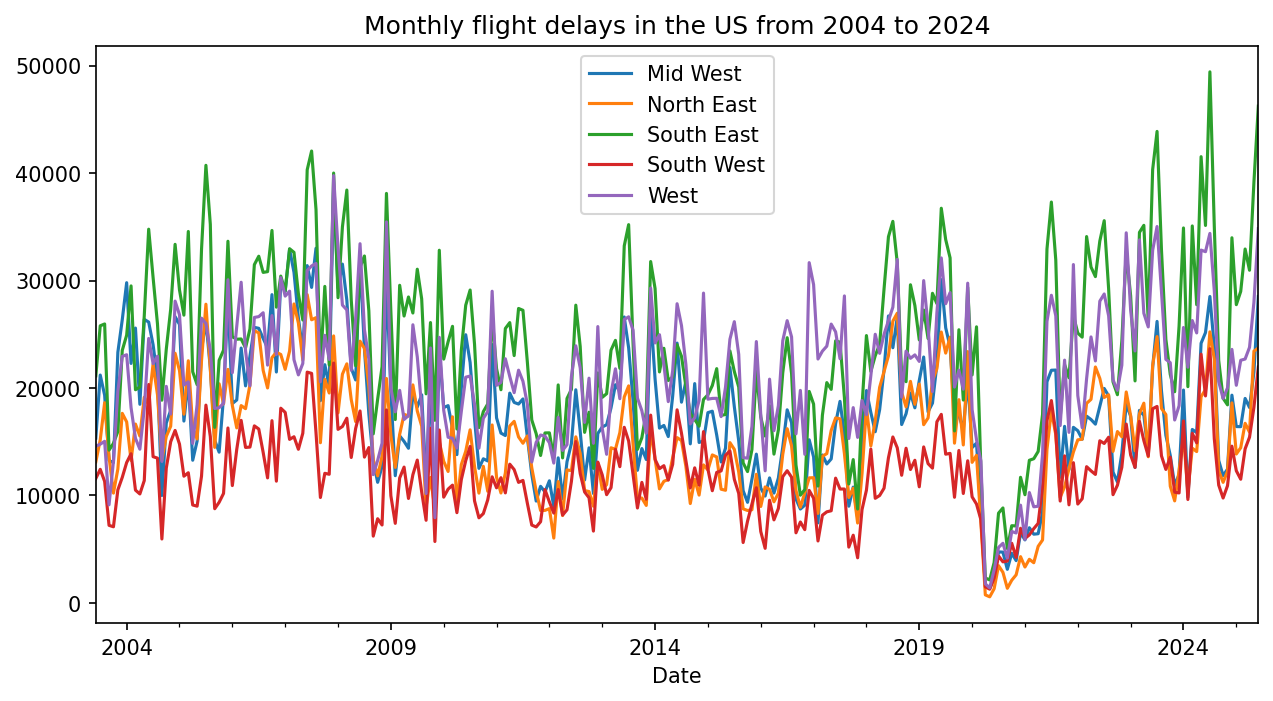

In [50]:
#fig, ax = plt.subplots()
plt.figure(figsize=(10, 5), dpi=150)
for region in delays_df['region'].unique():
    plot_df = delays_df[delays_df['region'] == region]
    #ax.figure(figsize=(10, 5), dpi=150) 
    plot_df['value'].plot(label=region)
    plt.title('Monthly flight delays in the US from {} to {}'.format('2004', '2024'))
    plt.xlabel('Date')
plt.legend()
plt.show()

This plot highlights how monthly delays evolve over time across all regions. The South East and West consistently show higher delay volumes with strong seasonal patterns, while the North East and South West remain lower and more stable. The sharp dip around 2020 reflects nationwide reductions in flight activity during the pandemic. These patterns show clear regional differences that justify forecasting each region separately.

## Exploring delay patterns

We visualize historical delays to observe seasonality, level shifts, and differences across regions. These patterns inform which model families are suitable for forecasting and reveal structural features that matter for accuracy.

In [41]:
print("---- Descriptive Statistics ----")
print(delays_df.describe())
print("---- Checking for missing values ----")
print(delays_df.isnull().sum())

print("---- Additional Info ----")
print(delays_df.info())

print("---- First 5 Rows ----")
delays_df.head()

---- Descriptive Statistics ----
              value
count   1325.000000
mean   18028.221132
std     7572.975322
min      570.000000
25%    12550.000000
50%    17268.000000
75%    22898.000000
max    49417.000000
---- Checking for missing values ----
region    0
value     0
dtype: int64
---- Additional Info ----
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1325 entries, 2003-06-01 to 2025-06-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  1325 non-null   object 
 1   value   1325 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.1+ KB
None
---- First 5 Rows ----


,region,value
date,,
2003-06-01,Mid West,15341.0
2003-06-01,North East,13133.0
2003-06-01,South East,21133.0
2003-06-01,South West,11583.0
2003-06-01,West,14584.0


No missing values were encountered in this dataset, so there was no need to find missing indexes or fill missing data

### Distribution of Monthly Delay Values

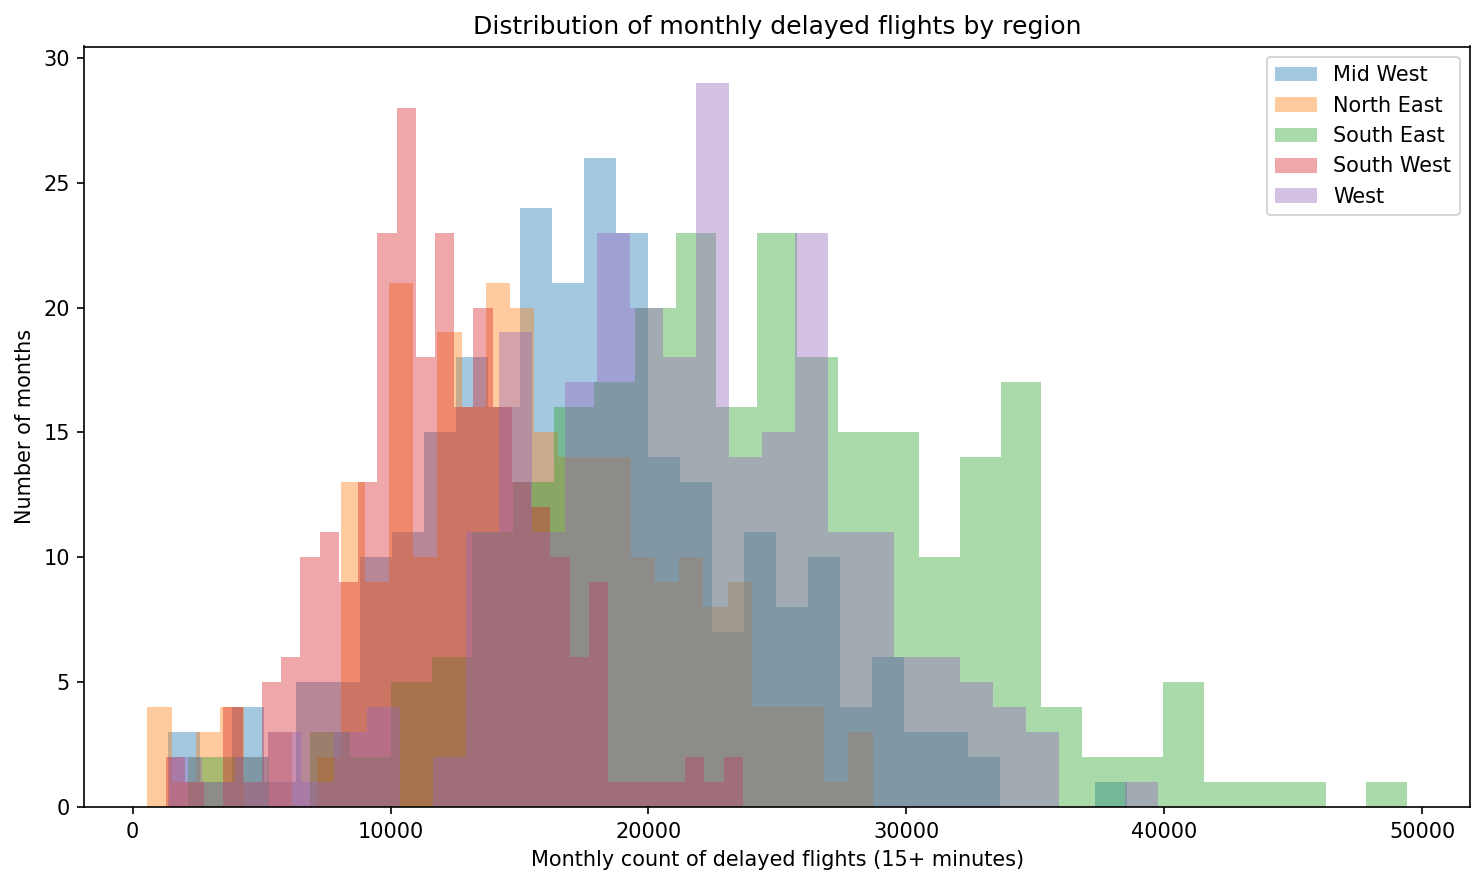

In [42]:
plt.figure(figsize=(10, 6), dpi=150)

for region in delays_df["region"].unique():
    subset = delays_df[delays_df["region"] == region]["value"]
    plt.hist(
        subset,
        bins=30,
        alpha=0.4,
        label=region
    )

plt.title("Distribution of monthly delayed flights by region")
plt.xlabel("Monthly count of delayed flights (15+ minutes)")
plt.ylabel("Number of months")
plt.legend()
plt.tight_layout()
plt.show()

The histogram shows the distribution of monthly delay counts across regions. The South East and West exhibit long right tails, indicating months with extreme congestion or severe weather events. The Mid West shows a more compact distribution, while the North East and South West generally fall on the lower end. These differences help explain which regions are more predictable and which experience occasional high-impact disruptions.

### Variation in Monthly Delays by Region

<Figure size 1200x900 with 0 Axes>

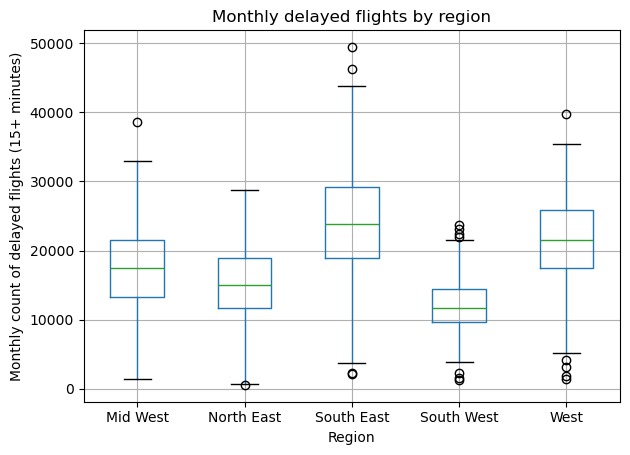

In [43]:
plt.figure(figsize=(8, 6), dpi=150)

# Each box = distribution of monthly delay counts for a region
delays_df.boxplot(column="value", by="region")

plt.title("Monthly delayed flights by region")
plt.suptitle("")  # remove automatic pandas title
plt.xlabel("Region")
plt.ylabel("Monthly count of delayed flights (15+ minutes)")
plt.tight_layout()
plt.show()


The boxplot emphasizes the spread and central tendency of delays for each region. The South East has the highest median delays and the widest IQR, 
showing substantial variability. The West also shows a wide range with several high outliers, driven by large hub airports. The Mid West stays 
near the middle and is more stable. The North East and South West have the lowest medians and tighter distributions. This confirms the regional 
differences seen in the histogram and provides a clearer view of outliers.

### Long Term Monthly Delay Trends by Region


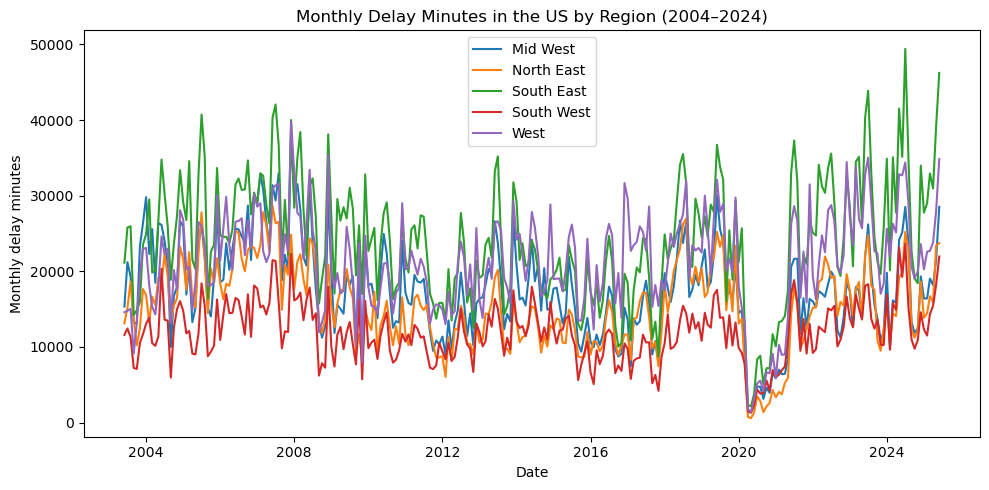

In [46]:
plt.figure(figsize=(10, 5))

for region in delays_df['region'].unique():
    # subset for this region
    region_df = delays_df[delays_df['region'] == region]
    # use the datetime index on the x axis and 'value' on the y axis
    plt.plot(region_df.index, region_df['value'], label=region)

plt.title('Monthly Delay Minutes in the US by Region (2004–2024)')
plt.xlabel('Date')
plt.ylabel('Monthly delay minutes')
plt.legend()
plt.tight_layout()
plt.show()


The chart shows clear regional differences in monthly delay minutes from 2004 to 2024. The South East and West regularly reach higher delay levels and show more frequent spikes, while the North East and South West stay comparatively lower and steadier. All regions follow a repeating seasonal rhythm, and there is a sharp drop across every region in early 2020 followed by a gradual rebound.

### Seasonal Pattern of Delays by Month and Region

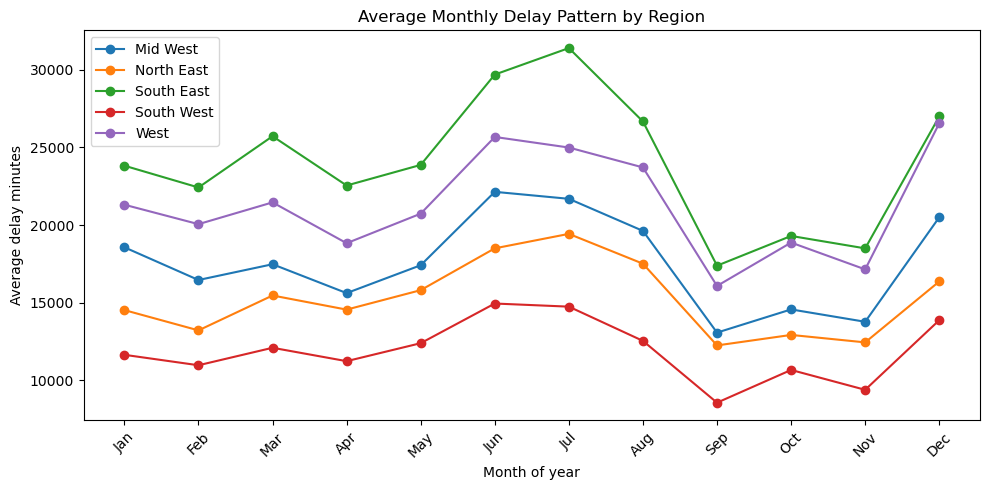

In [47]:
# Creating month of year column from the datetime index
delays_df = delays_df.copy()
delays_df['month'] = delays_df.index.month

# Average delay by region and month-of-year
seasonal_df = (
    delays_df
    .groupby(['region', 'month'], as_index=False)['value']
    .mean()
)

plt.figure(figsize=(10, 5))

for region in seasonal_df['region'].unique():
    region_month = seasonal_df[seasonal_df['region'] == region]
    plt.plot(
        region_month['month'],
        region_month['value'],
        marker='o',
        label=region
    )

plt.title('Average Monthly Delay Pattern by Region')
plt.xlabel('Month of year')
plt.ylabel('Average delay minutes')
plt.xticks(
    range(1, 13),
    ['Jan','Feb','Mar','Apr','May','Jun',
     'Jul','Aug','Sep','Oct','Nov','Dec'],
    rotation=45
)
plt.legend()
plt.tight_layout()
plt.show()


All regions show higher delays in summer, with clear peaks in June and July. The South East and West have the largest seasonal delays, while the North East and South West remain lower. Delays dip sharply in September before rising again toward December.

### Average Annual Delay Minutes by Region

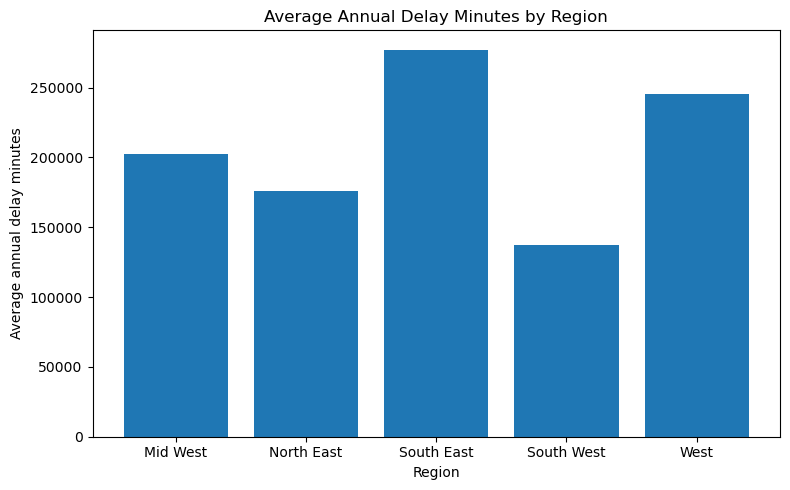

In [49]:
# Creating year column from the datetime index
delays_df = delays_df.copy()
delays_df['year'] = delays_df.index.year

# Total delay per region-year
annual_df = (
    delays_df
    .groupby(['region', 'year'], as_index=False)['value']
    .sum()
)

# Average annual delay per region across all years
region_means = (
    annual_df
    .groupby('region', as_index=False)['value']
    .mean()
    .rename(columns={'value': 'avg_annual_delay'})
)

plt.figure(figsize=(8, 5))
plt.bar(region_means['region'], region_means['avg_annual_delay'])
plt.title('Average Annual Delay Minutes by Region')
plt.xlabel('Region')
plt.ylabel('Average annual delay minutes')
plt.tight_layout()
plt.show()


The South East has the highest average annual delays, followed by the West. The Mid West and North East sit in the middle, and the South West has the lowest overall delay burden.

### Region-by-Month Heatmap of Average Delay Minutes

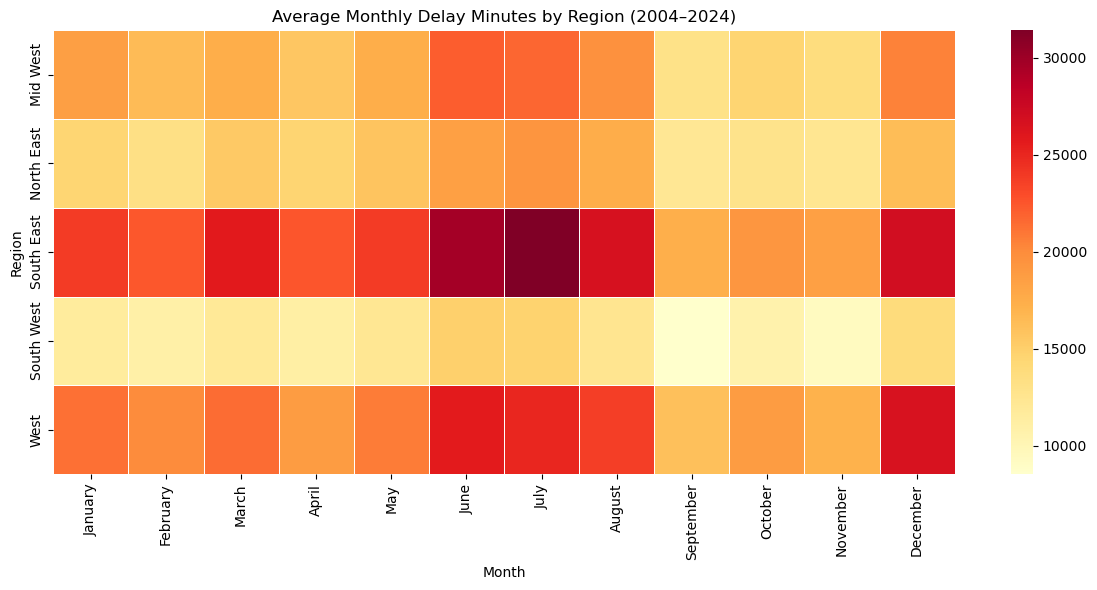

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract month for grouping
delays_df['month_num'] = delays_df.index.month
delays_df['month_name'] = delays_df.index.month_name()

# Pivot table: average delay minutes by region and month
heatmap_data = delays_df.pivot_table(
    values='value',
    index='region',
    columns='month_name',
    aggfunc='mean'
)

# Reorder months for readability
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
heatmap_data = heatmap_data[month_order]

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.5)

plt.title('Average Monthly Delay Minutes by Region (2004–2024)')
plt.xlabel('Month')
plt.ylabel('Region')
plt.tight_layout()
plt.show()


The heatmap shows strong summer peaks in delay minutes across all regions, with the South East and West experiencing the highest congestion in June through August. The North East shows a milder seasonal pattern, while the South West remains the lowest and most stable. These differences highlight distinct regional seasonality, reinforcing the need for region-specific forecasting.

## Modeling Approach

We evaluate standard time series models for each region, including ETS and ARIMA based specifications. A train–test split is used to measure out of sample accuracy. The objective is to select stable, interpretable models rather than exhaustively tuned ones.

### Why Use Multiple Models and Multiple Regions

Delay behavior differs across regions, with some showing strong seasonality and others displaying irregular spikes. Using multiple models and expanding the region set step-by-step shows how predictable each region is, how seasonality affects performance, and how model stability changes across different historical windows.

Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Fitting model: ARIMA(1,0,1)


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=848.781, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=851.791, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=851.251, Time=0.03 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

 ARIMA(0,0,1)(0,0,0)[0]             : AIC=846.906, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=846.713, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=848.451, Time=0.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=848.668, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=846.849, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=851.551, Time=0.04 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.739 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=849.402, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=853.788, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=846.149, Time=0.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=841.114, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=851.791, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=849.480, Time=0.04 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=845.588, Time=0.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=845.616, Time=0.31 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=843.869, Time=0.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=847.527, Time=0.40 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=849.426, Time=0.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=844.138, Time=0.45 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=844.123, Time=0.32 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=844.825, Time=0.25 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=839.192, Time=0.59 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.27 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=848.048, Time=0.32 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.83 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=846.338, Time=0.20 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=846.265, Time=2.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=846.469, Time=0.61 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,1)[12] intercept   : AIC=838.478, Time=0.59 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=inf, Time=0.34 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(1,0,1)[12] intercept   : AIC=838.523, Time=0.80 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,2)[12] intercept   : AIC=839.851, Time=2.15 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(1,0,0)[12] intercept   : AIC=840.287, Time=0.64 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(1,0,2)[12] intercept   : AIC=inf, Time=2.39 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,1)[12] intercept   : AIC=845.443, Time=0.61 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,1)[12] intercept   : AIC=846.517, Time=0.40 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,1)[12]             : AIC=inf, Time=0.63 sec

Best model:  ARIMA(1,0,3)(0,0,1)[12] intercept
Total fit time: 17.539 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was

Fitting model: ARIMA(1,0,1)
Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2513.896, Time=0.23 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2542.423, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2530.702, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2517.542, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2519.526, Time=0.10 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2519.041, Time=0.10 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2508.959, Time=0.31 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2513.571, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.66 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2508.117, Time=0.51 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2519.156, Time=0.20 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2510.197, Time=0.65 sec

Best model:  ARIMA(2,0,3)(0,0,0)[0]          
Total fit time: 3.220 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2472.754, Time=1.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2544.300, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2504.476, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2468.728, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2542.423, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2519.415, Time=0.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2470.470, Time=0.87 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=2470.439, Time=3.64 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2495.034, Time=0.11 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=6.33 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=2499.620, Time=0.48 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=2470.673, Time=0.88 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=2470.533, Time=1.15 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=2477.674, Time=0.76 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=2477.392, Time=1.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12]             : AIC=2467.070, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=2517.542, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12]             : AIC=2468.755, Time=0.73 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12]             : AIC=2468.714, Time=1.30 sec
 ARIMA(0,0,1)(1,0,0)[12]             : AIC=2493.101, Time=0.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12]             : AIC=2470.699, Time=2.98 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[12]             : AIC=2497.941, Time=0.22 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12]             : AIC=2480.872, Time=0.34 sec
 ARIMA(0,0,2)(0,0,1)[12]             : AIC=2481.126, Time=0.19 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12]             : AIC=2476.067, Time=0.51 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12]             : AIC=2482.974, Time=0.36 sec

Best model:  ARIMA(0,0,1)(0,0,1)[12]          
Total fit time: 25.220 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was

Fitting model: ARIMA(1,0,1)
Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_fi

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3436.142, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3484.155, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3465.980, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3443.251, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3444.807, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3443.040, Time=0.11 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3430.198, Time=0.43 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3436.841, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=3426.946, Time=0.64 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3427.117, Time=0.50 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=3430.136, Time=0.75 sec

Best model:  ARIMA(3,0,3)(0,0,0)[0]          
Total fit time: 3.121 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3392.164, Time=1.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3486.144, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3429.355, Time=0.16 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3372.454, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3484.155, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3445.414, Time=0.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=3374.093, Time=1.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=3373.986, Time=4.96 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=3407.381, Time=0.40 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=5.11 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=3418.178, Time=0.54 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=3374.328, Time=1.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=3374.333, Time=1.23 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=3386.939, Time=0.89 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=3383.057, Time=1.72 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12]             : AIC=3370.460, Time=0.66 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=3443.251, Time=0.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12]             : AIC=3372.099, Time=0.81 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12]             : AIC=3371.984, Time=2.62 sec
 ARIMA(0,0,1)(1,0,0)[12]             : AIC=3410.104, Time=0.11 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12]             : AIC=inf, Time=5.27 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[12]             : AIC=3416.242, Time=0.28 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12]             : AIC=3372.332, Time=0.73 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12]             : AIC=3372.338, Time=0.62 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12]             : AIC=3384.988, Time=0.54 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12]             : AIC=3389.627, Time=0.59 sec

Best model:  ARIMA(0,0,1)(0,0,1)[12]          
Total fit time: 32.378 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was

Fitting model: ARIMA(1,0,1)
Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4546.284, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4528.976, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4520.713, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4521.203, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4521.026, Time=0.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4523.017, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4522.750, Time=0.08 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.041 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4548.275, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4479.926, Time=0.18 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4410.546, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4546.284, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=4522.750, Time=0.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=4412.242, Time=1.38 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=4412.183, Time=6.18 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=4472.337, Time=0.15 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=6.59 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=4448.925, Time=0.54 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=4412.484, Time=1.51 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=4412.486, Time=1.47 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=4417.660, Time=1.16 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=4423.004, Time=2.19 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12]             : AIC=4408.580, Time=0.87 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=4520.713, Time=0.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12]             : AIC=4410.273, Time=0.99 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12]             : AIC=4410.213, Time=3.69 sec
 ARIMA(0,0,1)(1,0,0)[12]             : AIC=4470.307, Time=0.11 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12]             : AIC=inf, Time=9.97 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[12]             : AIC=4446.949, Time=0.31 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12]             : AIC=4410.510, Time=0.68 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12]             : AIC=4410.520, Time=0.86 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12]             : AIC=4415.698, Time=0.61 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12]             : AIC=4407.403, Time=1.49 sec
 ARIMA(1,0,2)(0,0,0)[12]             : AIC=4523.017, Time=0.13 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12]             : AIC=inf, Time=1.53 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,2)[12]             : AIC=inf, Time=6.60 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[12]             : AIC=4473.617, Time=0.29 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,2)[12]             : AIC=inf, Time=8.59 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12]             : AIC=inf, Time=1.76 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,1)[12]             : AIC=inf, Time=1.48 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,1)[12]             : AIC=4412.017, Time=1.45 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12]             : AIC=4412.365, Time=0.90 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,1)[12]             : AIC=4438.823, Time=1.45 sec

Best model:  ARIMA(1,0,2)(0,0,1)[12]          
Total fit time: 68.658 seconds


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


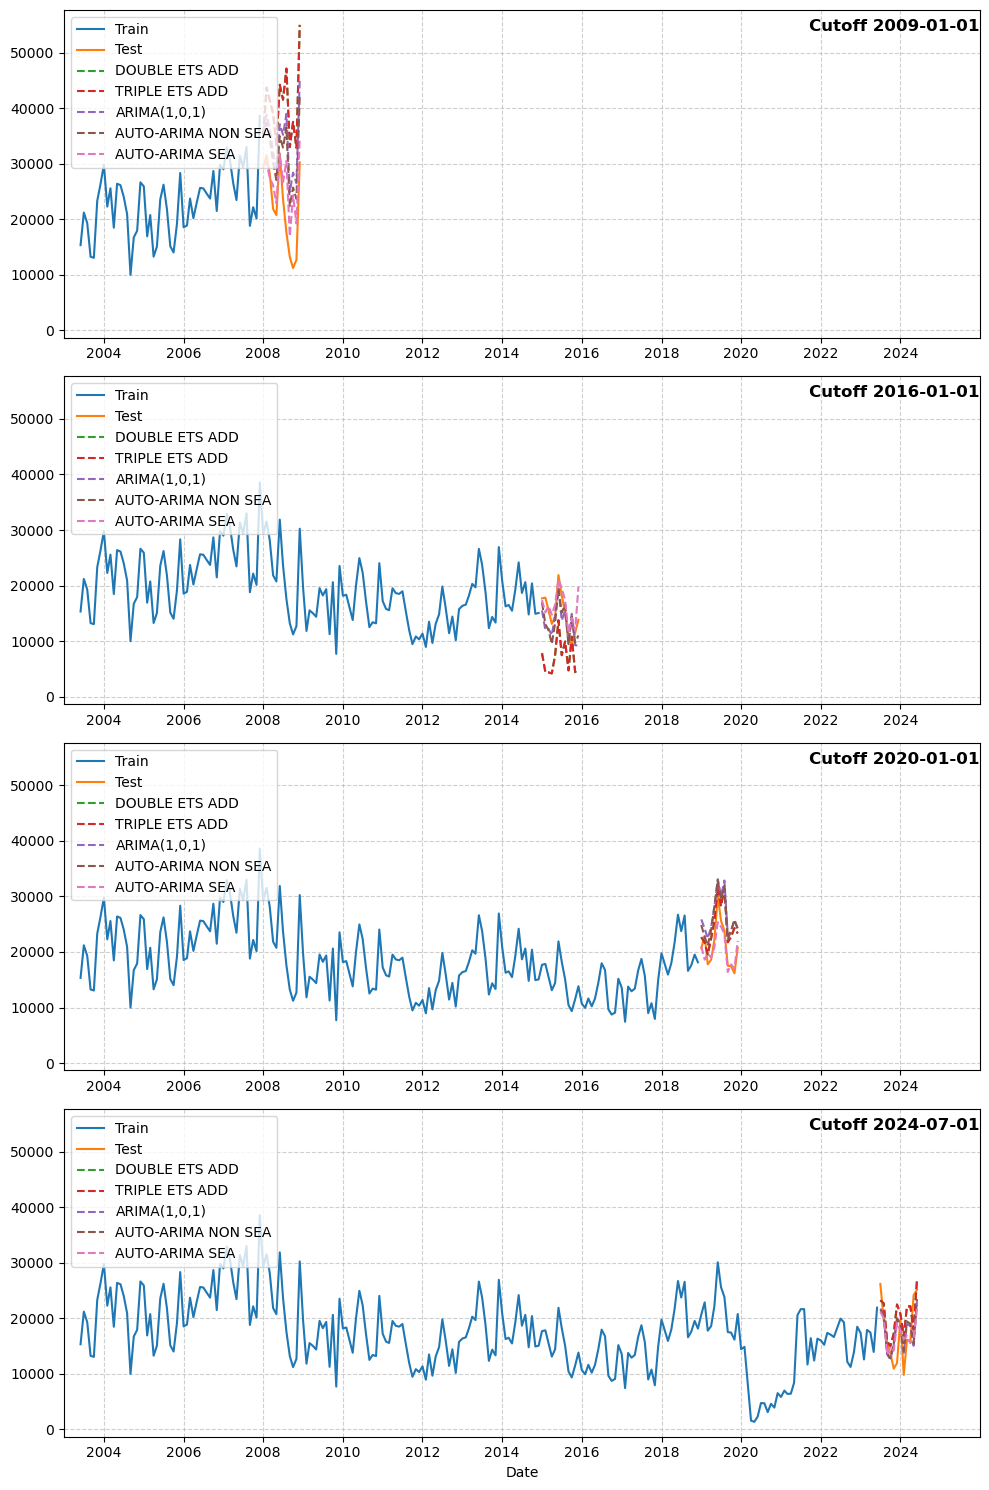


--- Model Evaluation Results ---
      Region      Cutoff               Model           MAE           MSE        R2            ME
0   Mid West  2009-01-01      DOUBLE ETS ADD  17644.172776  3.546286e+08 -5.592733  29520.443627
1   Mid West  2009-01-01      TRIPLE ETS ADD  17644.172776  3.546286e+08 -5.592733  29520.443627
2   Mid West  2009-01-01        ARIMA(1,0,1)  11343.481524  1.495544e+08 -1.780296  21378.885204
3   Mid West  2009-01-01  AUTO-ARIMA NON SEA   9181.247679  1.019954e+08 -0.896148  18953.053236
4   Mid West  2009-01-01      AUTO-ARIMA SEA   4397.266993  3.733484e+07  0.305926  13121.117845
5   Mid West  2016-01-01      DOUBLE ETS ADD   8122.846101  7.522225e+07 -5.277751  13427.059300
6   Mid West  2016-01-01      TRIPLE ETS ADD   8122.846101  7.522225e+07 -5.277751  13427.059300
7   Mid West  2016-01-01        ARIMA(1,0,1)   2877.361861  1.165521e+07  0.027303   5869.928380
8   Mid West  2016-01-01  AUTO-ARIMA NON SEA   2633.433788  8.886465e+06  0.258371   5104.852

C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

Fitting model: ARIMA(1,0,1)
Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=814.773, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=814.215, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=810.042, Time=0.03 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=811.796, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.899 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=816.752, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=813.455, Time=0.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=804.452, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=814.773, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=811.796, Time=0.04 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=806.398, Time=0.54 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=806.381, Time=1.57 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=807.290, Time=0.24 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=813.815, Time=0.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.51 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=812.520, Time=0.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=808.237, Time=0.62 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12]             : AIC=803.965, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=810.042, Time=0.04 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12]             : AIC=805.901, Time=0.30 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12]             : AIC=805.886, Time=0.72 sec
 ARIMA(0,0,1)(1,0,0)[12]             : AIC=805.587, Time=0.15 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(0,0,0)(0,0,1)[12]             : AIC=810.878, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12]             : AIC=inf, Time=0.38 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12]             : AIC=inf, Time=0.25 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12]             : AIC=809.211, Time=0.22 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12]             : AIC=805.191, Time=0.36 sec

Best model:  ARIMA(0,0,1)(0,0,1)[12]          
Total fit time: 11.490 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD
Fitting model: ARIMA(1,0,1)


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was

Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2403.856, Time=0.16 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2427.982, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2414.605, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2402.562, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2401.752, Time=0.10 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2403.701, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2404.080, Time=0.15 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2402.762, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2413.950, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2403.533, Time=0.12 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.065 seconds
Fitting model: AUTO-ARIMA SEA


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2367.520, Time=1.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2429.938, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2388.343, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2427.982, Time=0.03 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=2366.840, Time=1.26 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=2405.330, Time=0.38 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=2368.682, Time=6.10 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.16 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=6.64 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=2361.646, Time=1.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=2405.719, Time=0.37 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=2370.636, Time=1.40 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=2369.774, Time=4.42 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=2371.195, Time=0.70 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=4.78 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.85 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.84 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,1)[12] intercept   : AIC=inf, Time=1.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,1)[12] intercept   : AIC=2349.698, Time=1.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[12] intercept   : AIC=2402.626, Time=0.28 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(1,0,1)[12] intercept   : AIC=inf, Time=1.29 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,2)[12] intercept   : AIC=inf, Time=5.10 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(1,0,0)[12] intercept   : AIC=2367.259, Time=0.81 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(1,0,2)[12] intercept   : AIC=inf, Time=5.40 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,1)[12]             : AIC=inf, Time=0.78 sec

Best model:  ARIMA(0,0,3)(0,0,1)[12] intercept
Total fit time: 48.072 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was

Fitting model: ARIMA(1,0,1)
Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3298.106, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3331.060, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3313.160, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3297.307, Time=0.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3295.635, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3298.156, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3297.773, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3296.313, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3309.919, Time=0.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3297.542, Time=0.26 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.179 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3250.759, Time=1.94 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3333.060, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3278.330, Time=0.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3231.747, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3331.060, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3299.499, Time=0.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=3233.676, Time=1.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=3233.686, Time=2.98 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=3262.773, Time=0.13 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.23 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=3261.225, Time=0.57 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=3231.276, Time=1.02 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=3297.542, Time=0.23 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=3233.203, Time=1.33 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=5.98 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=3252.803, Time=0.98 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=6.25 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=3245.357, Time=0.93 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=3234.065, Time=1.14 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.65 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=3231.050, Time=1.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=3297.986, Time=0.24 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=3232.986, Time=1.46 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=3232.989, Time=6.00 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=3252.400, Time=0.71 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=6.95 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,1)[12] intercept   : AIC=inf, Time=1.30 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,1)[12] intercept   : AIC=inf, Time=1.44 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12]             : AIC=3229.088, Time=1.01 sec
 ARIMA(0,0,2)(0,0,0)[12]             : AIC=3296.313, Time=0.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,1)[12]             : AIC=inf, Time=0.80 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,2)[12]             : AIC=3231.031, Time=2.44 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,0)[12]             : AIC=3250.444, Time=0.34 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,2)[12]             : AIC=inf, Time=5.04 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12]             : AIC=3229.762, Time=0.66 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12]             : AIC=3233.464, Time=1.19 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,1)[12]             : AIC=3230.923, Time=1.20 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12]             : AIC=3229.315, Time=0.72 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,1)[12]             : AIC=3224.396, Time=1.50 sec
 ARIMA(1,0,3)(0,0,0)[12]             : AIC=3285.524, Time=0.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(1,0,1)[12]             : AIC=3226.281, Time=1.39 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,2)[12]             : AIC=3226.303, Time=5.44 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(1,0,0)[12]             : AIC=3251.216, Time=0.29 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(1,0,2)[12]             : AIC=inf, Time=8.73 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,1)[12]             : AIC=inf, Time=1.31 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12]             : AIC=inf, Time=1.40 sec

Best model:  ARIMA(1,0,3)(0,0,1)[12]          
Total fit time: 83.814 seconds
Fitting model: DOUBLE ETS ADD


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was

Fitting model: TRIPLE ETS ADD
Fitting model: ARIMA(1,0,1)
Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4395.444, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4417.862, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4394.854, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4396.443, Time=0.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4396.629, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4394.570, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4396.076, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4395.311, Time=0.14 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4398.200, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4396.566, Time=0.16 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.268 seconds
Fitting model: AUTO-ARIMA SEA


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=4285.309, Time=2.31 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4419.857, Time=0.04 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4336.697, Time=0.54 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4417.862, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.97 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=4347.452, Time=0.66 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=10.48 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=4306.459, Time=12.27 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=4397.423, Time=0.27 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=4286.549, Time=6.96 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=9.51 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=12.76 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=4280.945, Time=2.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.79 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=4337.521, Time=1.01 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=7.14 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=9.34 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=4397.287, Time=0.19 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=10.42 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=4315.832, Time=5.02 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=8.48 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.78 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.82 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(1,0,1)[12] intercept   : AIC=4287.379, Time=2.35 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.59 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(1,0,1)[12] intercept   : AIC=inf, Time=1.85 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=4290.145, Time=1.60 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,1)[12] intercept   : AIC=4303.150, Time=2.24 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12]             : AIC=inf, Time=1.64 sec

Best model:  ARIMA(1,0,2)(1,0,1)[12] intercept
Total fit time: 119.558 seconds


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


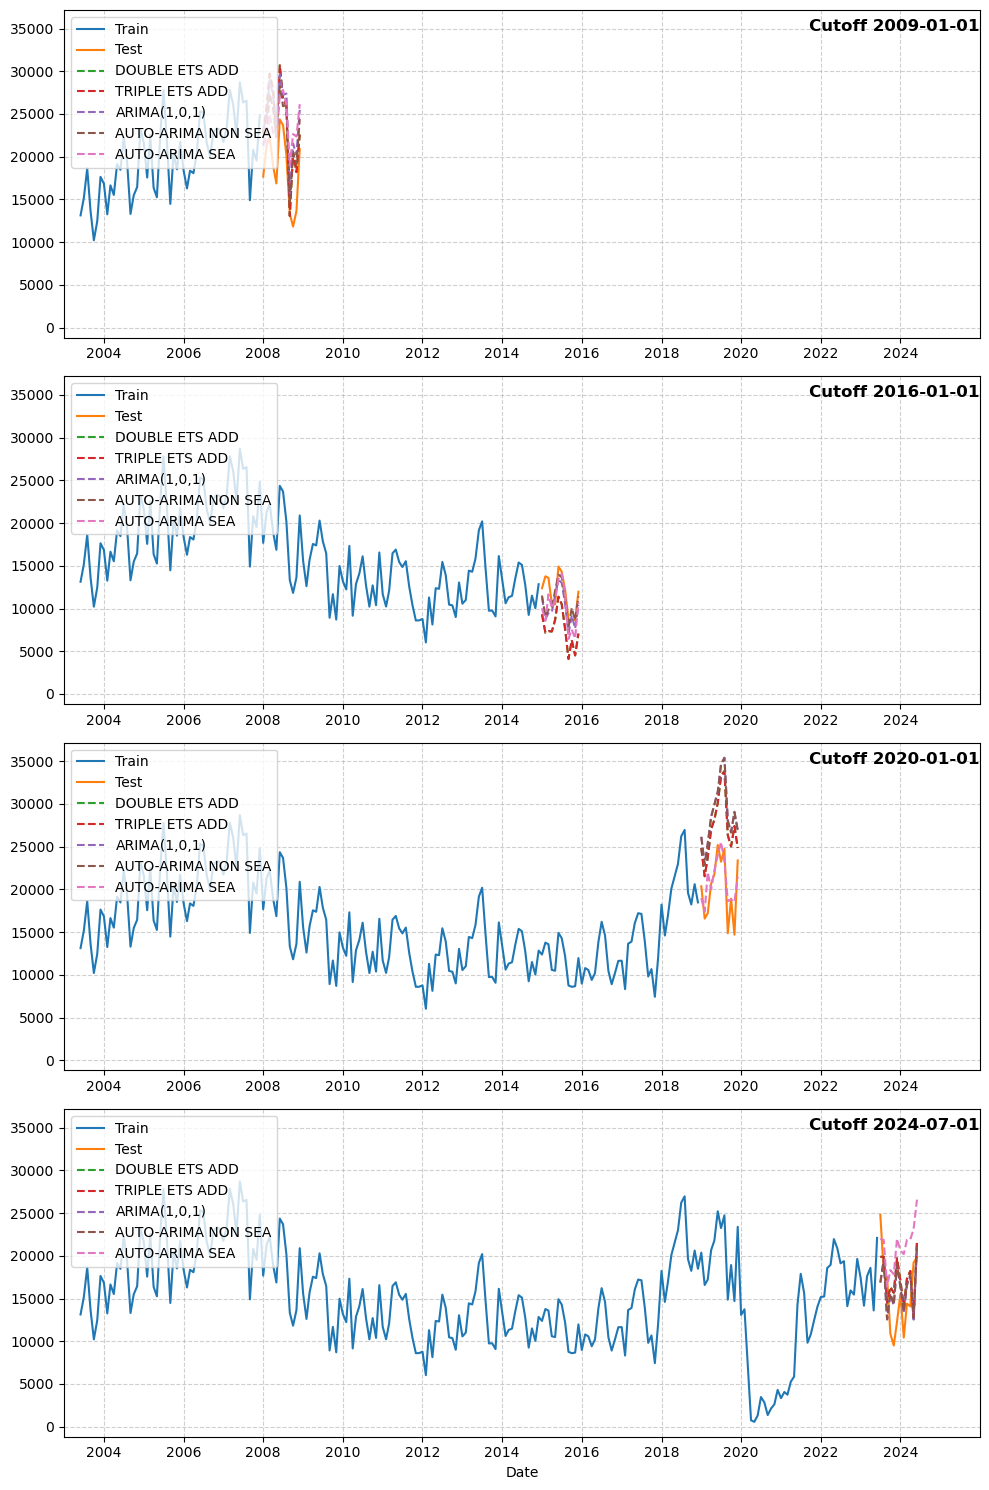


--- Model Evaluation Results ---
        Region      Cutoff               Model           MAE           MSE        R2            ME
0     Mid West  2009-01-01      DOUBLE ETS ADD  17644.172776  3.546286e+08 -5.592733  29520.443627
1     Mid West  2009-01-01      TRIPLE ETS ADD  17644.172776  3.546286e+08 -5.592733  29520.443627
2     Mid West  2009-01-01        ARIMA(1,0,1)  11343.481524  1.495544e+08 -1.780296  21378.885204
3     Mid West  2009-01-01  AUTO-ARIMA NON SEA   9181.247679  1.019954e+08 -0.896148  18953.053236
4     Mid West  2009-01-01      AUTO-ARIMA SEA   4397.266993  3.733484e+07  0.305926  13121.117845
5     Mid West  2016-01-01      DOUBLE ETS ADD   8122.846101  7.522225e+07 -5.277751  13427.059300
6     Mid West  2016-01-01      TRIPLE ETS ADD   8122.846101  7.522225e+07 -5.277751  13427.059300
7     Mid West  2016-01-01        ARIMA(1,0,1)   2877.361861  1.165521e+07  0.027303   5869.928380
8     Mid West  2016-01-01  AUTO-ARIMA NON SEA   2633.433788  8.886465e+06 

C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

Fitting model: ARIMA(1,0,1)
Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=862.431, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=874.555, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=876.261, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=868.147, Time=0.03 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

 ARIMA(1,0,2)(0,0,0)[0]             : AIC=867.405, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=861.099, Time=0.14 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=871.040, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=856.489, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=854.955, Time=0.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=856.663, Time=0.07 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 0.856 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=851.469, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=876.548, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=865.062, Time=0.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=874.555, Time=0.02 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=855.249, Time=0.65 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=858.947, Time=0.19 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=1.93 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=864.817, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=855.412, Time=2.34 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=849.497, Time=2.59 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=2.37 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=850.904, Time=1.00 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,0,0)[12] intercept   : AIC=845.851, Time=3.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=845.800, Time=0.92 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=860.277, Time=0.15 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,1)[12] intercept   : AIC=853.567, Time=0.41 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=853.331, Time=0.31 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,0,1)[12] intercept   : AIC=855.106, Time=1.63 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,0)[12] intercept   : AIC=849.906, Time=0.25 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(1,0,0)[12] intercept   : AIC=849.886, Time=0.33 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=850.123, Time=0.26 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=851.367, Time=0.74 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,0)[12]             : AIC=850.148, Time=0.27 sec

Best model:  ARIMA(3,0,2)(1,0,0)[12] intercept
Total fit time: 22.932 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD
Fitting model: ARIMA(1,0,1)


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was

Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2552.566, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2582.127, Time=0.03 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2578.293, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2560.873, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2555.007, Time=0.15 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2552.482, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2553.158, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2572.965, Time=0.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2538.730, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2537.787, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2539.571, Time=0.11 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.092 seconds


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2512.389, Time=1.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2584.005, Time=0.03 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2531.851, Time=0.37 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2582.127, Time=0.03 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=2507.880, Time=1.54 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=2555.546, Time=0.18 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=2514.963, Time=5.57 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=2525.942, Time=0.38 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=5.76 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.18 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.10 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=2491.547, Time=1.44 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=2540.088, Time=0.30 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,1)[12] intercept   : AIC=2483.258, Time=1.78 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=2507.654, Time=0.58 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,0,1)[12] intercept   : AIC=2503.531, Time=3.47 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,2)[12] intercept   : AIC=2503.347, Time=2.64 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,2)[12] intercept   : AIC=2484.876, Time=5.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,0,0)[12] intercept   : AIC=2503.955, Time=1.82 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,0,2)[12] intercept   : AIC=2505.078, Time=6.51 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,1)[12] intercept   : AIC=2484.138, Time=1.66 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(1,0,1)[12] intercept   : AIC=inf, Time=1.81 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=2496.918, Time=1.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,1)[12] intercept   : AIC=2492.780, Time=1.67 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,1)[12]             : AIC=2479.798, Time=1.64 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,1)[12]             : AIC=2480.048, Time=1.37 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,0)[12]             : AIC=2505.791, Time=0.46 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,0,1)[12]             : AIC=2501.436, Time=3.30 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,2)[12]             : AIC=2501.462, Time=3.11 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[12]             : AIC=2538.215, Time=0.29 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,2)[12]             : AIC=2485.398, Time=6.16 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,0,0)[12]             : AIC=2487.926, Time=4.99 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,0,2)[12]             : AIC=inf, Time=8.24 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,1)[12]             : AIC=2486.141, Time=1.51 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,1)[12]             : AIC=2478.251, Time=1.36 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,1)[12]             : AIC=2497.432, Time=0.33 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,0)[12]             : AIC=2505.247, Time=0.27 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,0,1)[12]             : AIC=2500.171, Time=2.41 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,2)[12]             : AIC=inf, Time=6.45 sec
 ARIMA(3,0,1)(0,0,0)[12]             : AIC=2538.730, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,2)[12]             : AIC=2478.609, Time=4.10 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,0,0)[12]             : AIC=2485.855, Time=3.10 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,0,2)[12]             : AIC=2502.194, Time=2.23 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12]             : AIC=2501.159, Time=0.38 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[12]             : AIC=2496.465, Time=0.36 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[12]             : AIC=2525.209, Time=0.21 sec

Best model:  ARIMA(3,0,1)(1,0,1)[12]          
Total fit time: 100.732 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD
Fitting model: ARIMA(1,0,1)


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was

Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3488.372, Time=0.16 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3533.960, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3527.185, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3502.237, Time=0.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3493.517, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3489.160, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3476.904, Time=0.23 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3474.959, Time=0.15 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3474.434, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3516.453, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3476.426, Time=0.10 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.224 seconds
Fitting model: AUTO-ARIMA SEA


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3431.558, Time=2.05 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3535.957, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3467.355, Time=0.51 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3411.262, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3533.960, Time=0.04 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3504.169, Time=0.18 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=3409.252, Time=1.20 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=3449.383, Time=0.41 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=3432.301, Time=5.68 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=4.91 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=3408.346, Time=3.13 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=3440.975, Time=3.31 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=3404.749, Time=5.86 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=3406.975, Time=1.18 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=3424.760, Time=6.62 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=3405.064, Time=1.33 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=3428.298, Time=2.49 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=3404.230, Time=3.10 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=3422.397, Time=0.70 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,2)[12] intercept   : AIC=3423.364, Time=5.38 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=3404.928, Time=1.45 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=3419.555, Time=2.76 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,2)[12] intercept   : AIC=3406.898, Time=4.97 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=3434.541, Time=8.69 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=3414.573, Time=6.94 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,2)[12] intercept   : AIC=3403.941, Time=5.88 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=3404.844, Time=0.80 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=11.98 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=3419.166, Time=0.36 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,2)[12]             : AIC=3395.635, Time=4.55 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[12]             : AIC=3395.224, Time=0.64 sec
 ARIMA(3,0,0)(0,0,0)[12]             : AIC=3474.434, Time=0.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[12]             : AIC=3416.911, Time=0.33 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,0)[12]             : AIC=3431.285, Time=0.22 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,2)[12]             : AIC=inf, Time=6.57 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[12]             : AIC=3421.453, Time=0.56 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,1)[12]             : AIC=3396.348, Time=1.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12]             : AIC=3421.328, Time=0.28 sec

Best model:  ARIMA(3,0,0)(0,0,1)[12]          
Total fit time: 107.165 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD
Fitting model: ARIMA(1,0,1)


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was

Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4650.538, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4641.891, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4636.888, Time=0.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4633.581, Time=0.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4633.733, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4625.528, Time=0.11 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4621.562, Time=0.16 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4622.619, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=4623.550, Time=0.21 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0]          
Total fit time: 1.843 seconds


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=4533.415, Time=2.37 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4652.532, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4579.301, Time=0.19 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4650.538, Time=0.04 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=4539.752, Time=2.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.98 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=9.84 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=7.29 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.73 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=4.71 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=4563.769, Time=2.58 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=10.96 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=4540.527, Time=1.94 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=4535.013, Time=1.75 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.53 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,1)[12] intercept   : AIC=4535.251, Time=2.23 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=4532.061, Time=1.75 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=4533.038, Time=1.45 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=1.23 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=4532.002, Time=9.04 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=4556.908, Time=4.66 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=8.56 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=9.52 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=9.02 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=8.22 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,1)[12] intercept   : AIC=4536.798, Time=9.46 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=4539.367, Time=9.18 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=4540.499, Time=5.75 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,0,1)[12] intercept   : AIC=4544.783, Time=8.70 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=4552.887, Time=3.21 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,1)[12]             : AIC=inf, Time=7.39 sec

Best model:  ARIMA(1,0,1)(2,0,1)[12] intercept
Total fit time: 149.239 seconds


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


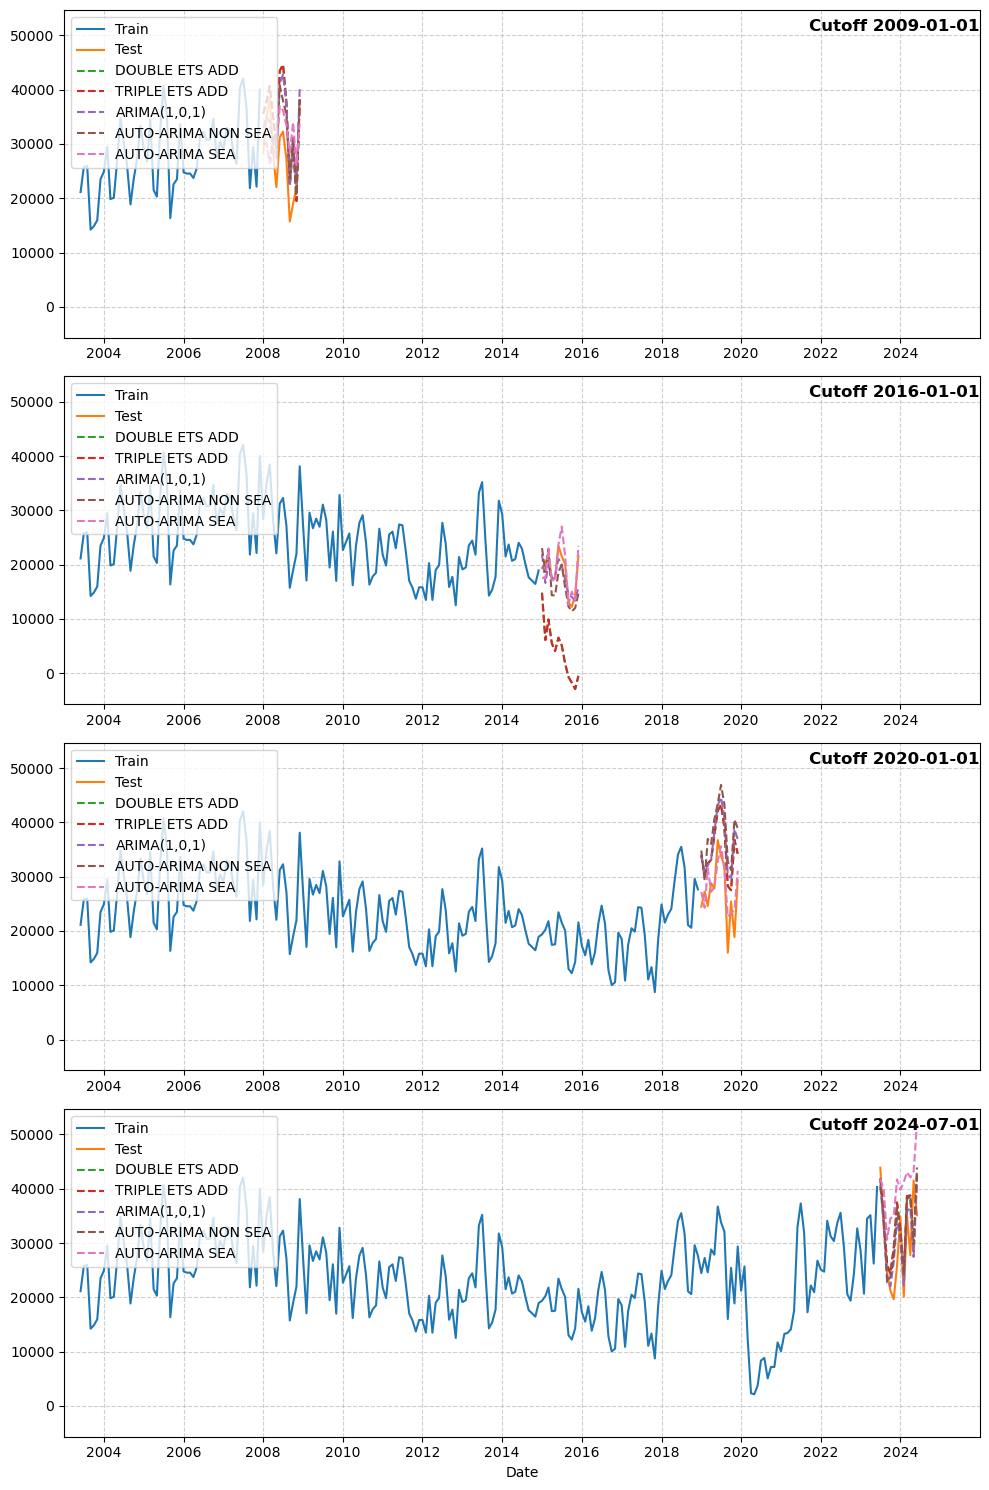


--- Model Evaluation Results ---
        Region      Cutoff               Model           MAE           MSE         R2            ME
0     Mid West  2009-01-01      DOUBLE ETS ADD  17644.172776  3.546286e+08  -5.592733  29520.443627
1     Mid West  2009-01-01      TRIPLE ETS ADD  17644.172776  3.546286e+08  -5.592733  29520.443627
2     Mid West  2009-01-01        ARIMA(1,0,1)  11343.481524  1.495544e+08  -1.780296  21378.885204
3     Mid West  2009-01-01  AUTO-ARIMA NON SEA   9181.247679  1.019954e+08  -0.896148  18953.053236
4     Mid West  2009-01-01      AUTO-ARIMA SEA   4397.266993  3.733484e+07   0.305926  13121.117845
5     Mid West  2016-01-01      DOUBLE ETS ADD   8122.846101  7.522225e+07  -5.277751  13427.059300
6     Mid West  2016-01-01      TRIPLE ETS ADD   8122.846101  7.522225e+07  -5.277751  13427.059300
7     Mid West  2016-01-01        ARIMA(1,0,1)   2877.361861  1.165521e+07   0.027303   5869.928380
8     Mid West  2016-01-01  AUTO-ARIMA NON SEA   2633.433788  8.88

C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

Fitting model: ARIMA(1,0,1)


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: F

Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=825.423, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=824.918, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=825.767, Time=0.03 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=815.982, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.193 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=810.030, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=827.398, Time=0.02 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=812.827, Time=0.21 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=802.080, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=825.423, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=801.365, Time=0.56 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=801.616, Time=0.52 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.41 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=811.242, Time=1.91 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=803.848, Time=1.67 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=800.384, Time=1.75 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=820.294, Time=0.21 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=803.414, Time=2.39 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=803.806, Time=1.84 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=812.193, Time=0.80 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=2.38 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,0,0)[12]             : AIC=inf, Time=0.74 sec

Best model:  ARIMA(0,0,1)(2,0,0)[12] intercept
Total fit time: 17.923 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Fitting model: ARIMA(1,0,1)
Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was re

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2407.971, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2443.547, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2427.344, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2405.092, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2404.148, Time=0.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2406.105, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2405.913, Time=0.13 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2403.974, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2406.425, Time=0.11 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2408.339, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2405.875, Time=0.19 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 1.209 seconds
Fitting model: AUTO-ARIMA SEA


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2445.492, Time=0.04 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2389.700, Time=0.38 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2443.547, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2429.294, Time=0.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2370.773, Time=2.20 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2366.348, Time=3.27 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.89 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=2367.733, Time=5.10 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=2368.650, Time=4.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=2360.154, Time=2.48 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=2358.920, Time=1.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.75 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=2383.057, Time=0.49 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=6.02 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=2422.774, Time=0.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=5.19 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=2365.627, Time=2.76 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=4.93 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.37 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=2346.958, Time=1.20 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.03 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=2369.544, Time=0.77 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,1)[12] intercept   : AIC=2362.267, Time=5.57 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=6.00 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=2408.016, Time=0.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=5.33 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=2353.546, Time=3.77 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=5.80 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,1)[12] intercept   : AIC=2348.414, Time=1.44 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.28 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,1)[12] intercept   : AIC=2363.764, Time=1.66 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12]             : AIC=inf, Time=0.98 sec

Best model:  ARIMA(2,0,1)(1,0,1)[12] intercept
Total fit time: 81.726 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was

Fitting model: ARIMA(1,0,1)
Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3341.032, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3321.287, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3296.520, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3294.426, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3295.971, Time=0.11 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3296.173, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3294.179, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3296.694, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3298.551, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3296.406, Time=0.10 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 1.247 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3343.024, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3282.231, Time=0.15 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3341.032, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=3323.298, Time=0.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=3258.056, Time=2.73 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=4.88 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.24 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=3298.912, Time=0.58 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=3251.641, Time=3.57 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=3273.485, Time=0.23 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=3239.871, Time=6.58 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.56 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=7.59 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=7.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,0,1)[12] intercept   : AIC=3236.607, Time=7.13 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=3233.899, Time=1.88 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=3224.537, Time=1.31 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=3306.780, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,2)[12] intercept   : AIC=3232.199, Time=7.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=3254.873, Time=0.76 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=6.47 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=3231.420, Time=1.24 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.48 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.25 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[12]             : AIC=inf, Time=0.64 sec

Best model:  ARIMA(3,0,0)(0,0,1)[12] intercept
Total fit time: 68.569 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Fitting model: ARIMA(1,0,1)
Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was re

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4363.319, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4348.575, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4342.332, Time=0.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4339.840, Time=0.11 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4340.960, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4346.299, Time=0.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4341.967, Time=0.15 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.625 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4365.306, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4293.210, Time=0.19 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4363.319, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4350.574, Time=0.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=4279.000, Time=0.77 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=6.14 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.99 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=4302.527, Time=0.72 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=4257.468, Time=4.14 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=4289.326, Time=0.26 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=6.27 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.60 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,0,0)[12] intercept   : AIC=4253.037, Time=3.85 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=4285.100, Time=0.29 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=10.15 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[12] intercept   : AIC=4229.029, Time=2.15 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=1.49 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=10.69 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=4346.434, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=8.21 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=10.97 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.38 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=4231.544, Time=1.79 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[12]             : AIC=inf, Time=1.19 sec

Best model:  ARIMA(3,0,0)(1,0,1)[12] intercept
Total fit time: 78.104 seconds


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


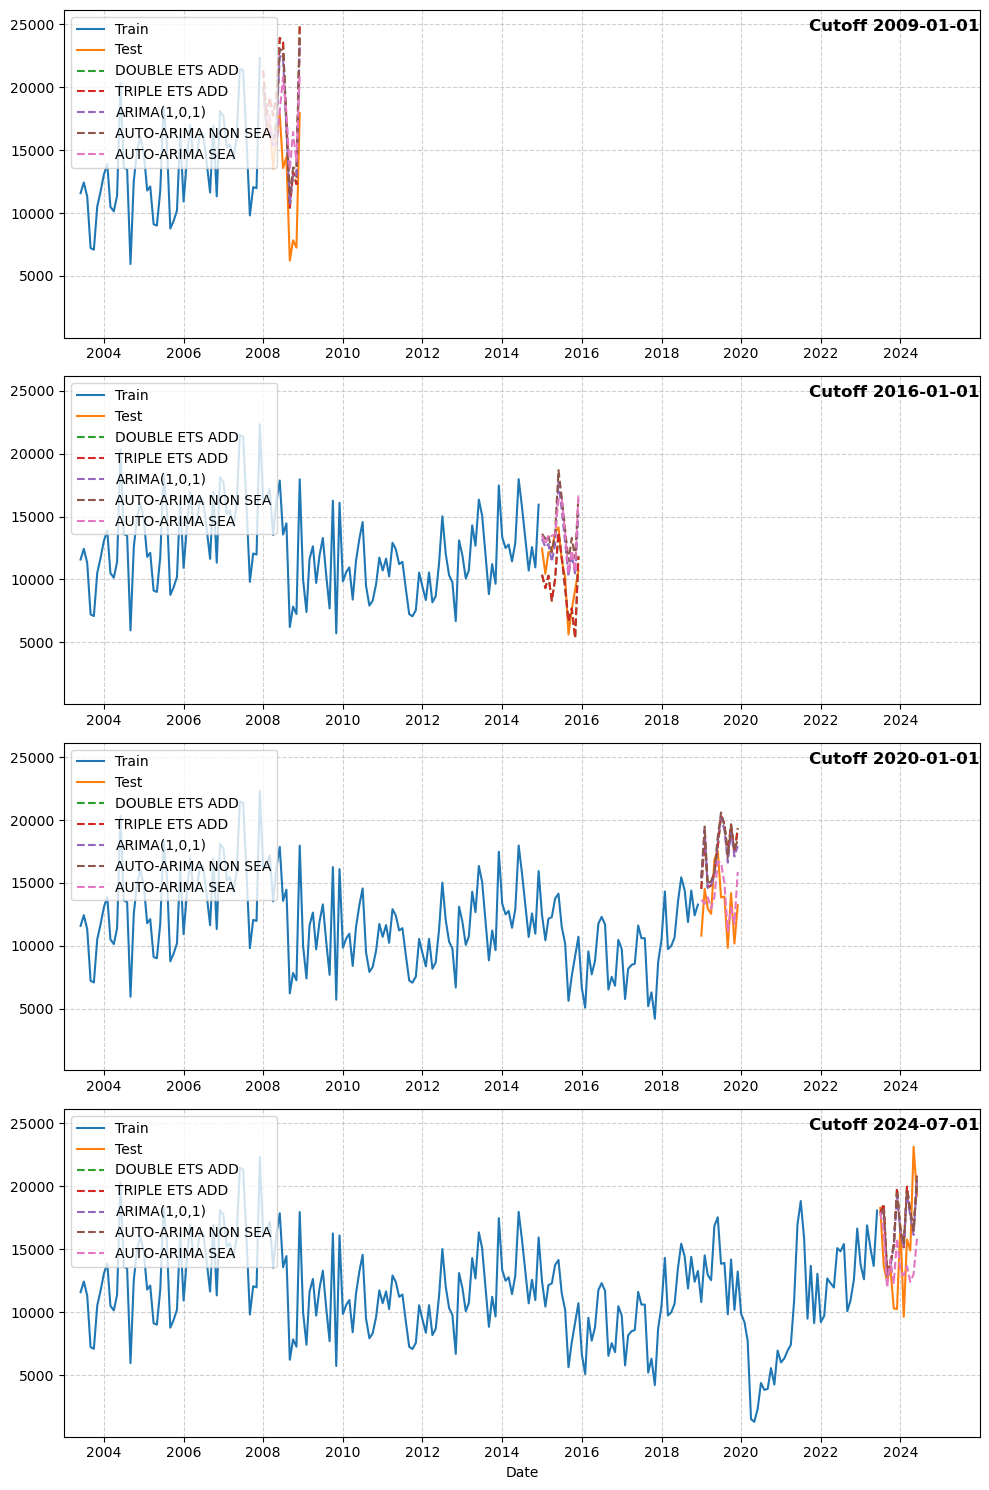


--- Model Evaluation Results ---
        Region      Cutoff               Model           MAE           MSE         R2            ME
0     Mid West  2009-01-01      DOUBLE ETS ADD  17644.172776  3.546286e+08  -5.592733  29520.443627
1     Mid West  2009-01-01      TRIPLE ETS ADD  17644.172776  3.546286e+08  -5.592733  29520.443627
2     Mid West  2009-01-01        ARIMA(1,0,1)  11343.481524  1.495544e+08  -1.780296  21378.885204
3     Mid West  2009-01-01  AUTO-ARIMA NON SEA   9181.247679  1.019954e+08  -0.896148  18953.053236
4     Mid West  2009-01-01      AUTO-ARIMA SEA   4397.266993  3.733484e+07   0.305926  13121.117845
5     Mid West  2016-01-01      DOUBLE ETS ADD   8122.846101  7.522225e+07  -5.277751  13427.059300
6     Mid West  2016-01-01      TRIPLE ETS ADD   8122.846101  7.522225e+07  -5.277751  13427.059300
7     Mid West  2016-01-01        ARIMA(1,0,1)   2877.361861  1.165521e+07   0.027303   5869.928380
8     Mid West  2016-01-01  AUTO-ARIMA NON SEA   2633.433788  8.88

C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=832.724, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=831.524, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=822.897, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=823.825, Time=0.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.823 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=820.766, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=834.724, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=827.398, Time=0.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=832.724, Time=0.02 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.73 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.68 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=822.280, Time=3.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.70 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.35 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=820.588, Time=1.34 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.47 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=819.444, Time=1.97 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=817.614, Time=0.56 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=826.331, Time=0.20 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=824.247, Time=0.67 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.61 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,2)[12] intercept   : AIC=826.146, Time=2.48 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=826.594, Time=0.13 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=824.034, Time=0.60 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.30 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=818.259, Time=0.62 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.51 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=820.213, Time=0.77 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12]             : AIC=inf, Time=0.41 sec

Best model:  ARIMA(2,0,1)(0,0,1)[12] intercept
Total fit time: 21.195 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD
Fitting model: ARIMA(1,0,1)


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was

Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2484.435, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2509.334, Time=0.03 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2495.174, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2480.833, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2481.259, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2480.803, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2482.523, Time=0.12 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2482.644, Time=0.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2484.632, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2482.684, Time=0.09 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 0.924 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2450.416, Time=1.67 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2511.300, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2477.890, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2509.334, Time=0.03 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=2448.064, Time=1.50 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=2486.275, Time=0.19 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=6.43 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=2468.181, Time=0.71 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=6.45 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.02 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=2435.735, Time=1.10 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=2484.509, Time=0.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=2450.190, Time=1.20 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=4.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=2466.928, Time=0.28 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=4.66 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.88 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.73 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.12 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.75 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[12] intercept   : AIC=2452.563, Time=0.24 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=2445.267, Time=1.33 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12]             : AIC=inf, Time=0.76 sec

Best model:  ARIMA(2,0,1)(0,0,1)[12] intercept
Total fit time: 36.180 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was

Fitting model: ARIMA(1,0,1)
Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fin

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3421.273, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3456.305, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3439.417, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3420.174, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3419.732, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3419.322, Time=0.16 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3422.029, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3421.295, Time=0.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3420.098, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3420.313, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3423.284, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3421.310, Time=0.11 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 1.251 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=3375.649, Time=1.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3458.297, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3414.792, Time=0.13 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3357.084, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3456.305, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3422.164, Time=0.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=3359.100, Time=1.20 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=3358.508, Time=3.12 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=3396.434, Time=0.14 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=4.95 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.38 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=3355.893, Time=0.90 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=3421.712, Time=0.13 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=3358.278, Time=1.21 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=3357.394, Time=4.95 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=3395.327, Time=0.25 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=7.65 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=3374.235, Time=0.97 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.21 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.50 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=3355.792, Time=1.06 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=3420.743, Time=0.10 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=3357.258, Time=1.37 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=5.00 sec
 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=3394.073, Time=0.18 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=6.67 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,1)[12] intercept   : AIC=3358.429, Time=1.36 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,1)[12] intercept   : AIC=inf, Time=1.58 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12]             : AIC=3354.135, Time=0.53 sec
 ARIMA(0,0,2)(0,0,0)[12]             : AIC=3418.711, Time=0.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,1)[12]             : AIC=3355.610, Time=1.23 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,2)[12]             : AIC=3355.407, Time=2.68 sec
 ARIMA(0,0,2)(1,0,0)[12]             : AIC=3392.017, Time=0.14 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,2)[12]             : AIC=inf, Time=4.41 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12]             : AIC=3355.398, Time=0.52 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12]             : AIC=3356.131, Time=1.41 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,1)[12]             : AIC=3356.130, Time=0.73 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12]             : AIC=3354.246, Time=0.52 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,1)[12]             : AIC=3375.190, Time=0.30 sec

Best model:  ARIMA(0,0,2)(0,0,1)[12]          
Total fit time: 61.476 seconds
Fitting model: DOUBLE ETS ADD
Fitting model: TRIPLE ETS ADD
Fitting model: ARIMA(1,0,1)


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was

Fitting model: AUTO-ARIMA NON SEA
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4540.017, Time=0.18 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4558.774, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4545.139, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4538.212, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4539.321, Time=0.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4538.765, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4540.228, Time=0.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4540.208, Time=0.08 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.745 seconds
Fitting model: AUTO-ARIMA SEA
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=4465.512, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4560.770, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4504.348, Time=0.18 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4558.774, Time=0.05 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=2.35 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=4500.080, Time=0.78 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=9.80 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=10.55 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=4542.018, Time=0.29 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=4465.500, Time=3.50 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=inf, Time=7.60 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=inf, Time=9.46 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,2)[12] intercept   : AIC=4463.854, Time=14.09 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=4462.164, Time=2.79 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.73 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,1)[12] intercept   : AIC=4464.006, Time=2.91 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=2.28 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=10.69 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.71 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,1)[12] intercept   : AIC=4464.202, Time=2.19 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.48 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,1)[12] intercept   : AIC=4462.095, Time=2.01 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=4536.605, Time=0.49 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,1)[12] intercept   : AIC=4464.736, Time=2.66 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,2)[12] intercept   : AIC=4464.840, Time=8.95 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=inf, Time=2.08 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,2)[12] intercept   : AIC=inf, Time=12.81 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,1)[12] intercept   : AIC=inf, Time=1.77 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=4462.277, Time=0.59 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,1)[12]             : AIC=4460.853, Time=1.50 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[12]             : AIC=4534.607, Time=0.44 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,1)[12]             : AIC=4462.835, Time=2.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,2)[12]             : AIC=4462.843, Time=8.83 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,0)[12]             : AIC=inf, Time=1.77 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,2)[12]             : AIC=inf, Time=10.37 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,1)[12]             : AIC=inf, Time=1.87 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12]             : AIC=inf, Time=1.95 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,1)[12]             : AIC=4462.320, Time=1.49 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[12]             : AIC=4460.268, Time=0.54 sec
 ARIMA(1,0,2)(0,0,0)[12]             : AIC=4540.228, Time=0.17 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12]             : AIC=inf, Time=1.85 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,2)[12]             : AIC=inf, Time=7.35 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[12]             : AIC=4496.691, Time=0.31 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,2)[12]             : AIC=inf, Time=10.07 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,1)[12]             : AIC=inf, Time=1.19 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12]             : AIC=inf, Time=1.06 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12]             : AIC=inf, Time=0.46 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,1)[12]             : AIC=inf, Time=0.85 sec


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12]             : AIC=inf, Time=1.29 sec

Best model:  ARIMA(1,0,2)(0,0,1)[12]          
Total fit time: 172.575 seconds


C:\Users\shaha\Downloads\AnacondaNew\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


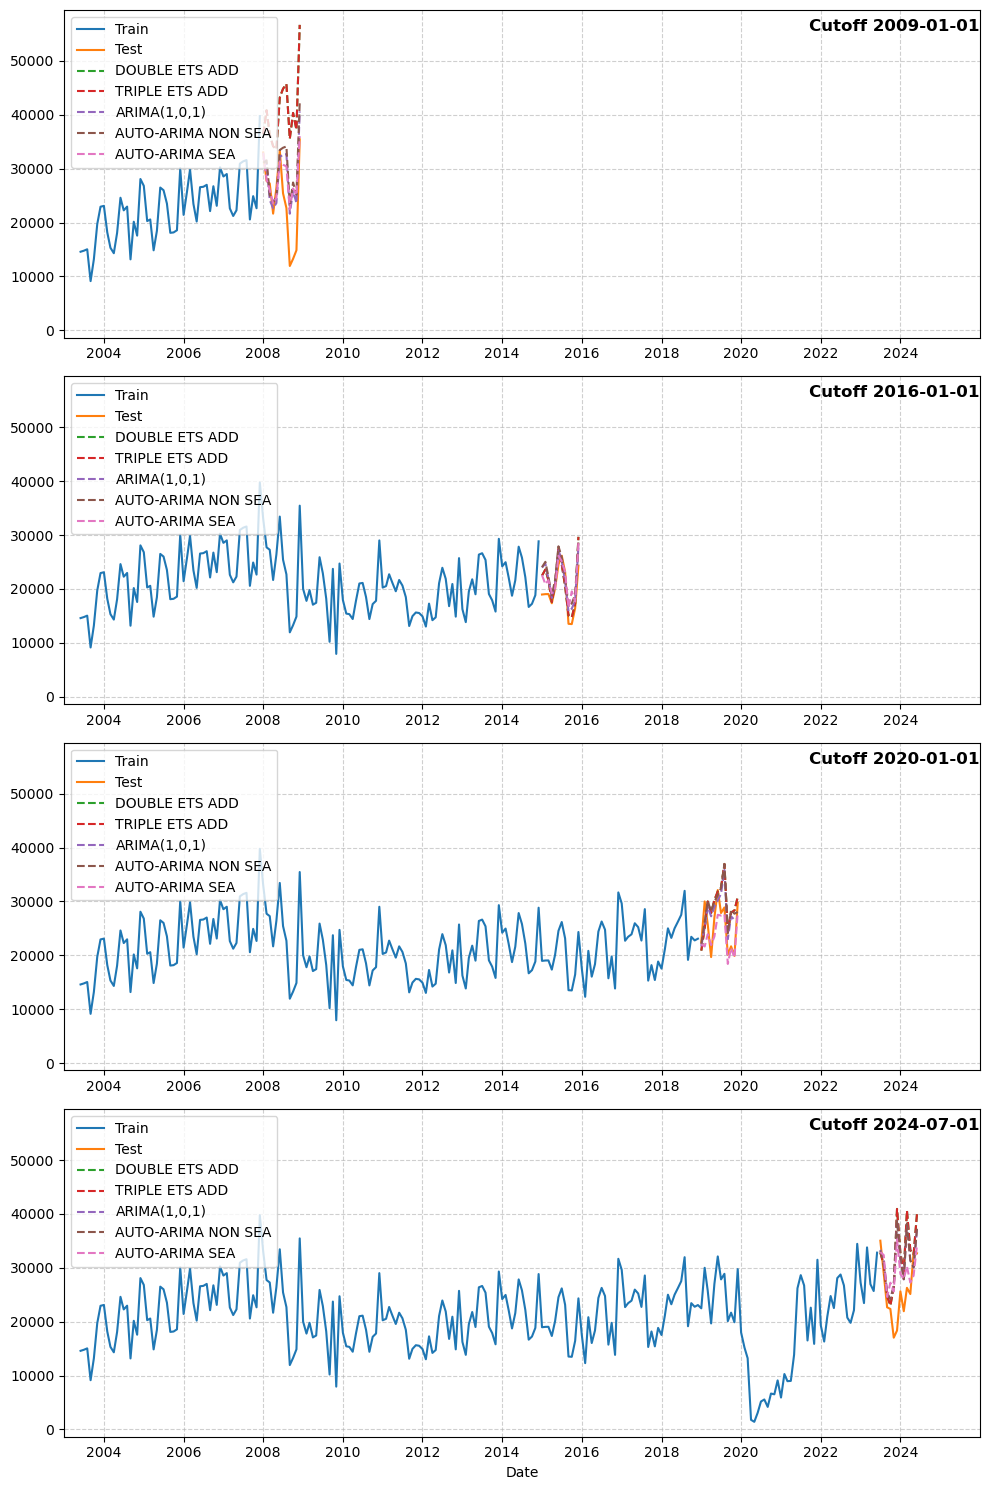


--- Model Evaluation Results ---
        Region      Cutoff               Model           MAE           MSE         R2            ME
0     Mid West  2009-01-01      DOUBLE ETS ADD  17644.172776  3.546286e+08  -5.592733  29520.443627
1     Mid West  2009-01-01      TRIPLE ETS ADD  17644.172776  3.546286e+08  -5.592733  29520.443627
2     Mid West  2009-01-01        ARIMA(1,0,1)  11343.481524  1.495544e+08  -1.780296  21378.885204
3     Mid West  2009-01-01  AUTO-ARIMA NON SEA   9181.247679  1.019954e+08  -0.896148  18953.053236
4     Mid West  2009-01-01      AUTO-ARIMA SEA   4397.266993  3.733484e+07   0.305926  13121.117845
5     Mid West  2016-01-01      DOUBLE ETS ADD   8122.846101  7.522225e+07  -5.277751  13427.059300
6     Mid West  2016-01-01      TRIPLE ETS ADD   8122.846101  7.522225e+07  -5.277751  13427.059300
7     Mid West  2016-01-01        ARIMA(1,0,1)   2877.361861  1.165521e+07   0.027303   5869.928380
8     Mid West  2016-01-01  AUTO-ARIMA NON SEA   2633.433788  8.88

In [6]:
# This cell fits five forecasting models to each region, across four cutoff dates.
# For every region–cutoff–model combination, it generates forecasts, plots them,
# and records error metrics that will be used in the model comparison section.

import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, mean_squared_log_error, r2_score

# Container to store results for every region–cutoff–model combination, this list is converted to results_df at the end of the cell.

results_list = []
for region in delays_df['region'].unique():
    region_df = delays_df[delays_df['region'] == region].drop(columns=['region'], axis=1)

    first_diff_df = region_df.diff().dropna()
    #first_diff_df.plot(color='blue')

    seasonal_diff_df = first_diff_df.diff(12).dropna()
    #seasonal_diff_df.plot(color = 'blue')
    
# Cutoff dates used to create different train–test windows, each date defines where the training period ends and the evaluation period begins.

    cutoffs = ["2009-01-01", "2016-01-01", "2020-01-01", "2024-07-01"]
    
# Each entry defines one model (ETS, ARIMA, or Auto ARIMA) and its parameters.
# These settings are applied consistently across all regions and cutoff dates.

    model_configs = {
        'DOUBLE ETS ADD': {
            'model': sm.tsa.ExponentialSmoothing,
            'params': {'trend': None, 'seasonal': 'add'}
        },
        'TRIPLE ETS ADD': {
            'model': sm.tsa.ExponentialSmoothing,
            'params': {'trend': None, 'seasonal': 'add', 'seasonal_periods': 12}
        },
        'ARIMA(1,0,1)': {
            'model': sm.tsa.ARIMA,
            'params': {'order': (1, 0, 1)}
        },
        'AUTO-ARIMA NON SEA': {
            'model': pm.auto_arima,
            'params': {'seasonal': False, 'trace' : True, 'm': 12, 'suppress_warnings': True, 'stepwise': True, 'test':'adf', 'max_p' : 3, 'max_q' : 3, 'd': None, 'error_action': 'ignore'}
        },
        'AUTO-ARIMA SEA': {
            'model': pm.auto_arima,
            'params': {'seasonal': True, 'trace' : True, 'm': 12, 'suppress_warnings': True, 'stepwise': True, 'test':'adf', 'max_p' : 3, 'max_q' : 3, 'd': None, 'error_action': 'ignore'}
        }
    }

# Error metrics used to evaluate forecasts.
# MAE and MSE capture error magnitude, R2 measures explained variance, and ME (max error) highlights worst miss in the test period.
    
    metrics = {
        'MAE': mean_absolute_error,
        'MSE': mean_squared_error,
        'R2': r2_score,
        'ME': max_error
    }

# Setting up a figure with one row per cutoff date.
# Each panel shows train data, test data, and forecasts for that cutoff.

    fig, axes = plt.subplots(
        nrows=len(cutoffs),
        ncols=1,
        figsize=(10, 15),
        sharey=True
    )

# Looping over the four cutoff dates.
# For each cutoff, splitting the data into a training segment and a 12 month test segment.

    for i, date in enumerate(cutoffs):
        ax = axes[i]
        
# Creating train–test batches in both differenced space (for modeling)
# and original space (for plotting and metric calculation).

        batch = seasonal_diff_df[seasonal_diff_df.index < date]
        first_diff_batch = first_diff_df[first_diff_df.index < date]
        plot_batch = region_df[region_df.index < date]
        
# Performing time ordered train–test split (no shuffling) in the differenced series.
# The test set always contains the last 12 months before the cutoff.

        train_data, test_data = train_test_split(batch, test_size=12, random_state=25, shuffle = False)
        first_diff_train, first_diff_test = train_test_split(first_diff_batch, test_size=12, random_state=25, shuffle = False)
        plot_train_data, plot_test_data = train_test_split(plot_batch, test_size=12, random_state=25, shuffle = False)

        seasonal_history = first_diff_train['value'].iloc[-12:].tolist()
        
# Performing time ordered train–test split (no shuffling) in the differenced series. The test set always contains the last 12 months before the cutoff.

        ax.plot(plot_train_data.index, plot_train_data['value'], label='Train')
        ax.plot(plot_test_data.index, plot_test_data['value'], label='Test')
        
# Fitting each model configuration to the training data and generate forecasts for the 12 month test period.

        for model_name, config in model_configs.items():
            print(f"Fitting model: {model_name}")
            
            try:
                if model_name == 'AUTO-ARIMA NON SEA' or model_name == 'AUTO-ARIMA SEA':
                    model_fit = config['model'](train_data['value'], **config['params'])
                    forecast_values = model_fit.predict(n_periods=len(test_data))
                else:
                    model = config['model'](train_data['value'], **config['params'])
                    model_fit = model.fit()
                    forecast_values = model_fit.forecast(steps=len(test_data))
                    
# Converting forecasts from differenced space back to the original delay levels by reversing seasonal and first differencing step by step.

                original_forecast = []
                for count, value in enumerate(forecast_values.tolist()):
                    inv_1st_order = value + seasonal_history[count]
                    if count == 0:
                        previous_value_original = plot_train_data.values.tolist()[-1][0]
                    else:
                        previous_value_original = inv_2nd_order
                    inv_2nd_order = inv_1st_order + previous_value_original
                    original_forecast.append(inv_2nd_order)
                    
# Creating a forecast series aligned with the test index, then overlaying the forecast on the train and test data in the plot.
                
                fc_series = pd.Series(original_forecast, index=test_data.index)

                ax.plot(fc_series, label=model_name, linestyle='--')
# Computing all error metrics for this region–cutoff–model combination and storing them in results_list for later comparison.

                result_row = {'Region': region, 'Cutoff': date, 'Model': model_name}
                for metric_name, metric_func in metrics.items():
                    score = metric_func(plot_test_data['value'], fc_series)
                    result_row[metric_name] = score
                results_list.append(result_row)
                
# If a model fails to fit for this region or cutoff, skip it and log the error.
            
            except Exception as e:
                print(f"Could not fit {model_name}. Error: {e}")
                
# Format the axes and labels for the current panel. The x axis uses year ticks, and the legend lists all models for this cutoff.

        ax.set_xlim([pd.Timestamp('2003-01-01'), pd.Timestamp('2025-12-31')])
        ax.set_title(f'Cutoff {date}', loc='right', fontweight='bold', y=1.0, pad=-15)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.YearLocator(2)) # Show a year marker every 2 years
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(loc='upper left')

    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

# Combining all stored rows into a single results table. results_df is used in the next section for model comparison.

    results_df = pd.DataFrame(results_list)
    print("\n--- Model Evaluation Results ---")
    print(results_df.to_string())

## Model comparison

The tables below summarize accuracy metrics for each model and region. We compare performance using measures such as RMSE. The best model for each region is selected based on lowest validation error.

In [8]:
results_df.groupby(['Region', 'Model']).mean(numeric_only=True)

MAE           MSE        R2  \
Region     Model                                                     
Mid West   ARIMA(1,0,1)        5784.336003  5.340381e+07 -0.658886   
           AUTO-ARIMA NON SEA  5056.923699  3.978552e+07 -0.307941   
           AUTO-ARIMA SEA      2806.232677  1.655502e+07  0.456888   
           DOUBLE ETS ADD      8459.372664  1.190626e+08 -2.766534   
           TRIPLE ETS ADD      8459.372664  1.190626e+08 -2.766534   
North East ARIMA(1,0,1)        5053.383028  3.690386e+07 -1.819861   
           AUTO-ARIMA NON SEA  4613.306928  3.292370e+07 -1.518462   
           AUTO-ARIMA SEA      3673.842830  2.185762e+07 -0.456373   
           DOUBLE ETS ADD      5098.783338  3.273267e+07 -1.967025   
           TRIPLE ETS ADD      5098.783338  3.273267e+07 -1.967025   
South East ARIMA(1,0,1)        5349.178971  4.799135e+07 -0.315817   
           AUTO-ARIMA NON SEA  6399.993184  6.324827e+07 -0.805448   
           AUTO-ARIMA SEA      5420.390353  5.662320e+07 -0.104595   
           DOUBLE ETS ADD      8762.062337  1.054963e+08 -4.735121   
           TRIPLE ETS ADD      8762.062337  1.054963e+08 -4.735121   
South West ARIMA(1,0,1)        3418.255026  1.717490e+07 -1.045043   
           AUTO-ARIMA NON SEA  3809.098895  2.072957e+07 -1.541751   
           AUTO-ARIMA SEA      2720.460413  1.295206e+07 -0.247602   
           DOUBLE ETS ADD      3540.159455  1.908218e+07 -1.115516   
           TRIPLE ETS ADD      3540.159455  1.908218e+07 -1.115516   
West       ARIMA(1,0,1)        4617.221614  3.561883e+07 -0.182389   
           AUTO-ARIMA NON SEA  4992.506727  4.145775e+07 -0.374543   
           AUTO-ARIMA SEA      3484.978621  2.483305e+07  0.224085   
           DOUBLE ETS ADD      7454.520285  1.080510e+08 -1.582913   
           TRIPLE ETS ADD      7454.520285  1.080510e+08 -1.582913   

                                         ME  
Region     Model                             
Mid West   ARIMA(1,0,1)        11469.486637  
           AUTO-ARIMA NON SEA  10591.469913  
           AUTO-ARIMA SEA       7905.218474  
           DOUBLE ETS ADD      15402.908969  
           TRIPLE ETS ADD      15402.908969  
North East ARIMA(1,0,1)         9266.128648  
           AUTO-ARIMA NON SEA   8868.279300  
           AUTO-ARIMA SEA       7655.358804  
           DOUBLE ETS ADD       8879.692286  
           TRIPLE ETS ADD       8879.692286  
South East ARIMA(1,0,1)        12688.686355  
           AUTO-ARIMA NON SEA  13111.917394  
           AUTO-ARIMA SEA      12150.254246  
           DOUBLE ETS ADD      16337.853212  
           TRIPLE ETS ADD      16337.853212  
South West ARIMA(1,0,1)         7335.714601  
           AUTO-ARIMA NON SEA   7972.181953  
           AUTO-ARIMA SEA       6935.793527  
           DOUBLE ETS ADD       7770.151785  
           TRIPLE ETS ADD       7770.151785  
West       ARIMA(1,0,1)        11608.368010  
           AUTO-ARIMA NON SEA  12296.550246  
           AUTO-ARIMA SEA      11099.500905  
           DOUBLE ETS ADD      15853.653856  
           TRIPLE ETS ADD      15853.653856

In [9]:
results_df

,Region,Cutoff,Model,MAE,MSE,R2,ME
0,Mid West,2009-01-01,DOUBLE ETS ADD,17644.172776,3.546286e+08,-5.592733,29520.443627
1,Mid West,2009-01-01,TRIPLE ETS ADD,17644.172776,3.546286e+08,-5.592733,29520.443627
2,Mid West,2009-01-01,"ARIMA(1,0,1)",11343.481524,1.495544e+08,-1.780296,21378.885204
3,Mid West,2009-01-01,AUTO-ARIMA NON SEA,9181.247679,1.019954e+08,-0.896148,18953.053236
4,Mid West,2009-01-01,AUTO-ARIMA SEA,4397.266993,3.733484e+07,0.305926,13121.117845
...,...,...,...,...,...,...,...
95,West,2024-07-01,DOUBLE ETS ADD,6909.009962,8.642264e+07,-1.864694,22571.550175
96,West,2024-07-01,TRIPLE ETS ADD,6909.009962,8.642264e+07,-1.864694,22571.550175
97,West,2024-07-01,"ARIMA(1,0,1)",6324.085120,6.756054e+07,-1.239463,20540.904195
98,West,2024-07-01,AUTO-ARIMA NON SEA,6324.709731,6.763173e+07,-1.241822,20522.314596


## Preparing RMSE comparisons

We compute or extract RMSE for each model and region, then aggregate these values to obtain a comparable measure of accuracy. The table is reshaped so regions form rows and models form columns. This structure makes it straightforward to identify which model achieves the lowest error for each region.

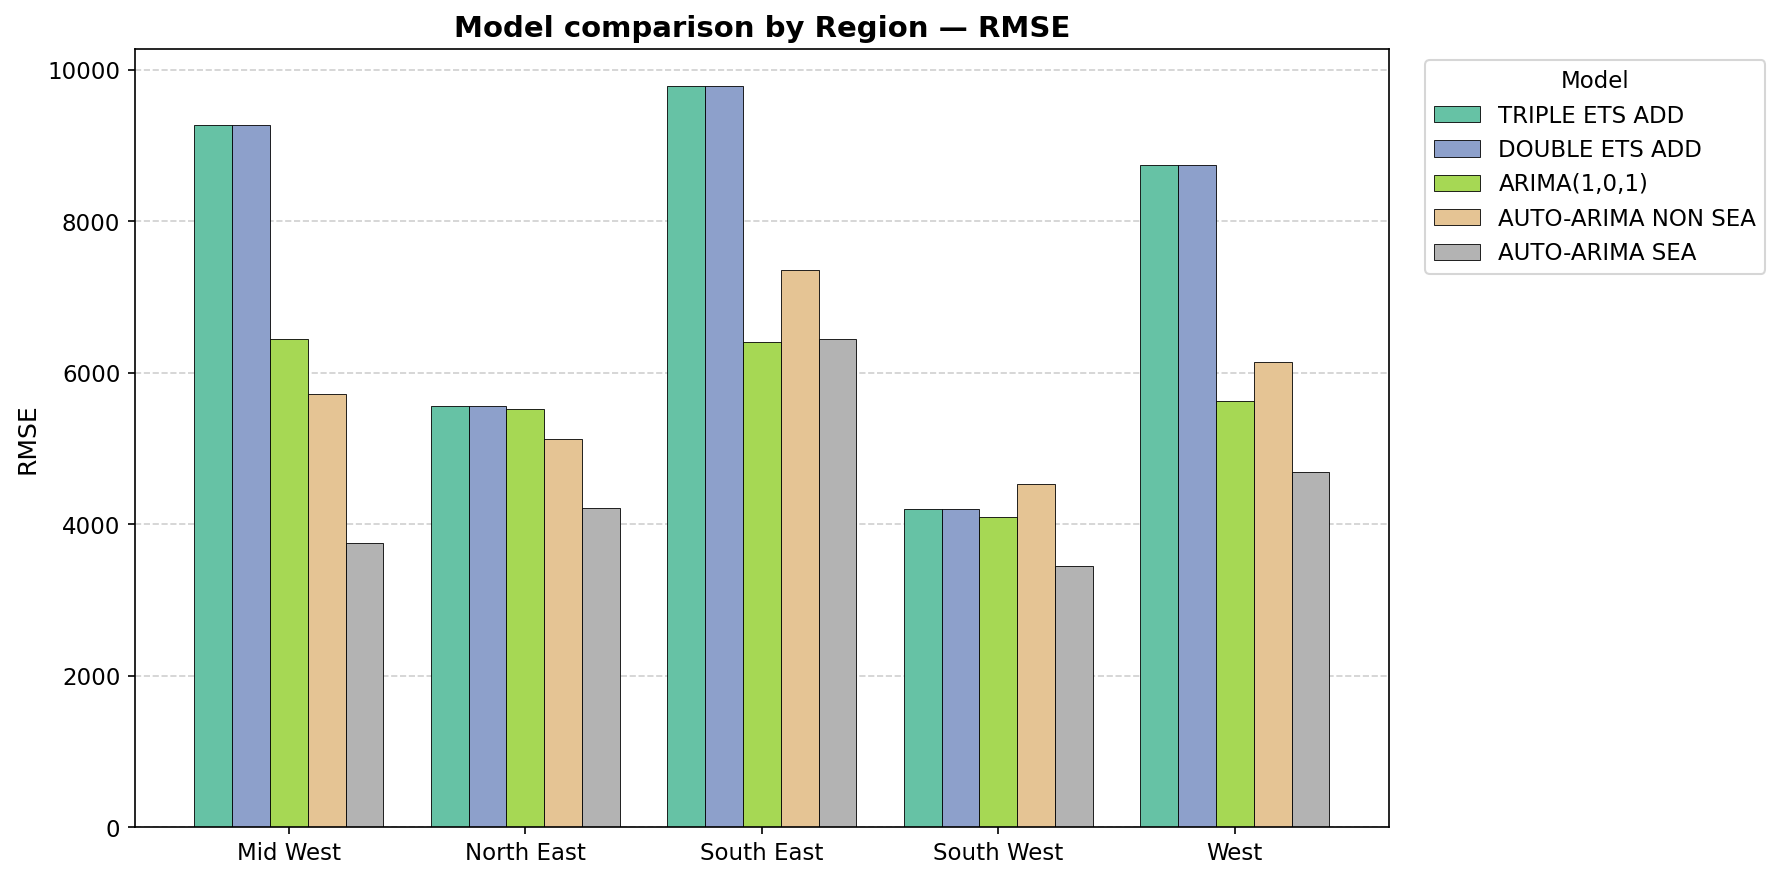

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 1) If your DF has MSE, compute RMSE. If you already have RMSE, skip this.
if 'RMSE' not in results_df.columns and 'MSE' in results_df.columns:
    results_df = results_df.copy()
    results_df['RMSE'] = np.sqrt(results_df['MSE'].astype(float))

# 2) Aggregate (mean) RMSE by Region and Model (in case there are repeats)
agg = (results_df
       .groupby(['Region', 'Model'], as_index=False)
       .RMSE
       .mean())

# 3) Pivot so Regions are rows and Models are columns (NaNs -> keep as NaN)
pivot = agg.pivot(index='Region', columns='Model', values='RMSE')

# Optional: define order of models if you want consistent ordering
model_order = [
    'TRIPLE ETS ADD',
    'DOUBLE ETS ADD',
    'ARIMA(1,0,1)',
    'AUTO-ARIMA NON SEA',
    'AUTO-ARIMA SEA',
]
# Keep only models present and in your preferred order
model_order = [m for m in model_order if m in pivot.columns]
pivot = pivot[model_order]

# 4) Plot — clean, professional style
plt.rcParams.update({
    "figure.autolayout": True,
    "font.size": 11
})
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

# Use pandas plotting (grouped bars) which wraps matplotlib; choose colormap
colors = plt.cm.Set2(np.linspace(0, 1, len(pivot.columns)))  # pleasant palette
pivot.plot(kind='bar', ax=ax, width=0.8, color=colors, edgecolor='black', linewidth=0.4)

# 5) Aesthetics
ax.set_title('Model comparison by Region — RMSE', fontsize=14, weight='bold')
ax.set_xlabel('')
ax.set_ylabel('RMSE', fontsize=12)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)    # horizontal grid
ax.set_axisbelow(True)
ax.legend(title='Model', bbox_to_anchor=(1.02, 1), loc='upper left')  # legend outside

# rotate x labels a bit for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

# 6) Annotate bars with RMSE values
# for p in ax.patches:
#     # p.get_height() is NaN for missing values; skip those
#     h = p.get_height()
#     if np.isfinite(h):
#         ax.annotate(f"{h:,.0f}",  # format as integer (change to {h:.1f} for decimals)
#                     (p.get_x() + p.get_width() / 2, h),
#                     ha='center', va='bottom', fontsize=9, xytext=(0, 4))

# 7) Save high-res copy (optional)
plt.savefig("model_comparison_rmse_by_region.png", dpi=300, bbox_inches='tight')

plt.show()



The table above summarizes the performance of every forecasting model across
all regions and cutoff periods using four metrics: MAE, MSE, R², and Max Error.
Each row represents a specific region–cutoff–model combination, which allows
direct comparison of how forecasting accuracy changes as the amount of training
data changes.

A few patterns stand out:

1. Seasonal Auto ARIMA (AUTO-ARIMA SEA) consistently delivers the lowest RMSE in almost every region.
Its advantage is strongest in regions with clear annual seasonality, such as the South East and West, and remains competitive even in more stable regions like the North East and South West.

2. ETS models (Double ETS ADD and Triple ETS ADD) generally show higher RMSE values compared to ARIMA-based models.
This is expected, since exponential smoothing models struggle when the series contains sharp volatility spikes or irregular weather-driven disruptions.

3. ARIMA(1,0,1) performs moderately well but is less reliable in regions with strong seasonal structure.
It performs best in cases where short-term autocorrelation dominates but cannot fully capture the recurring seasonal peaks that characterize high-delay regions.

4. R² values are mostly negative or near zero, indicating that delay volumes are difficult to predict with linear structure alone.
This is typical for aviation delay data, where extreme weather events or operational disruptions can cause sudden fluctuations.

5. Max Error (ME) highlights the difficulty of forecasting extreme delay months.
High ME values in the South East and West show how volatility and large spikes challenge forecasting models, especially around the 2020 pandemic disruption and the 2024 recovery window.

Summary

Seasonal Auto-ARIMA stands out as the preferred forecasting model due to its ability to capture both recurring seasonality and underlying trend components in monthly delay data. These results inform the final conclusions about regional predictability and which modeling choices are most effective.